In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown

# let's globally set the style of the plots
sns.set_palette("crest")
sns.set_style("whitegrid")

current_palette = sns.color_palette()

**Student Name:** Jason Coleman

**Student ID:** 9539719

In [2]:
df = pd.read_csv('bank.csv')
df

age           job   marital  education default  balance housing loan  \
0     32.0    technician    single   tertiary      no      392     yes   no   
1     39.0    technician  divorced  secondary      no      688     yes  yes   
2     59.0       retired   married  secondary      no     1035     yes  yes   
3     47.0   blue-collar   married  secondary      no      398     yes  yes   
4     54.0       retired   married  secondary      no     1004     yes   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
1995  20.0       student    single        NaN      no     2785      no   no   
1996  28.0        admin.    single  secondary      no      127      no   no   
1997  81.0       retired   married    primary      no     1154      no   no   
1998  46.0      services   married    primary      no     4343     yes   no   
1999  40.0  entrepreneur   married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0      cellular    1   apr       957         2    131         2  failure   
1      cellular    1   apr       233         2    133         1  failure   
2      cellular    1   apr       126         2    239         1  failure   
3      cellular    1   apr       274         1    238         2  failure   
4      cellular    1   apr       479         1    307         1  failure   
...         ...  ...   ...       ...       ...    ...       ...      ...   
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
0            no  
1            no  
2            no  
3            no  
4            no  
...         ...  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes  

[2000 rows x 17 columns]

# Executive Summary

- Task 1 explored the data set, looking at the big picture.
- Task 2 focused on cleaning and prepping the data for an ML pipeline. 
- The appendix contains some light testing to ensure the prep was successful (using pipelines to preprocess data for an SVM and a random forest classifier). 
- This data contains missing data, highly skewed fields and require various types of encoding (cyclical, one-hot and binary).
- The bank dataset can be used to build a classifier to predict if a respondent will subscribe or not. We are able to discern key data points that have significant impact on this decision: previous outcomes, month being the biggest factors.
- Weak correlations in the data suggest a non-linear combination of features may be required. This is borne out in the appendix were switching from a linear classifier to a non-linear (rbf SVM) classifier caused a jump from ~94% to 97% accuracy on test data.
- Use of a standard scaler improves a) the training time of SVMs. Fitting using data that has been processed with a standard scalers takes approx 5-9s on an M1 Ultra. Not using a standard scaler adds approx. 3 minutes to the fit time (on the same machine). b) Accuracy - the accuracy goes from 0.935 to 0.945 when you add the standard scaler.
- An SVM classifier was trained with an 80/20 train/test breakdown (using grid search to find appropriate parameters). It used a nonlinear (rbf) kernel. Test score accuracy for this classifier was **0.975**. 
- A random forest classifier gets a 0.97 accuracy on the test set.
- Both SVM and Random Forest sensitive to preprocessing - especially use of the standardscaler.
- Feature importance shows the main contributing features are: `month` and `poutcome`. This raises an interesting question about the chance that someone will subscribe if they have never been approached before. Is success really down to the month that you last contacted them in??? 

# The Process
The following illustration demonstrates the process I will follows. In this assignment I will perform Exploratory Data Analysis (EDA) and Data Preparation. This will yield a transformed data set that I can use with an ML algorithm. In my case I will will do some quick tests with a SVM (linear and non-linear) and a random forest classifier.
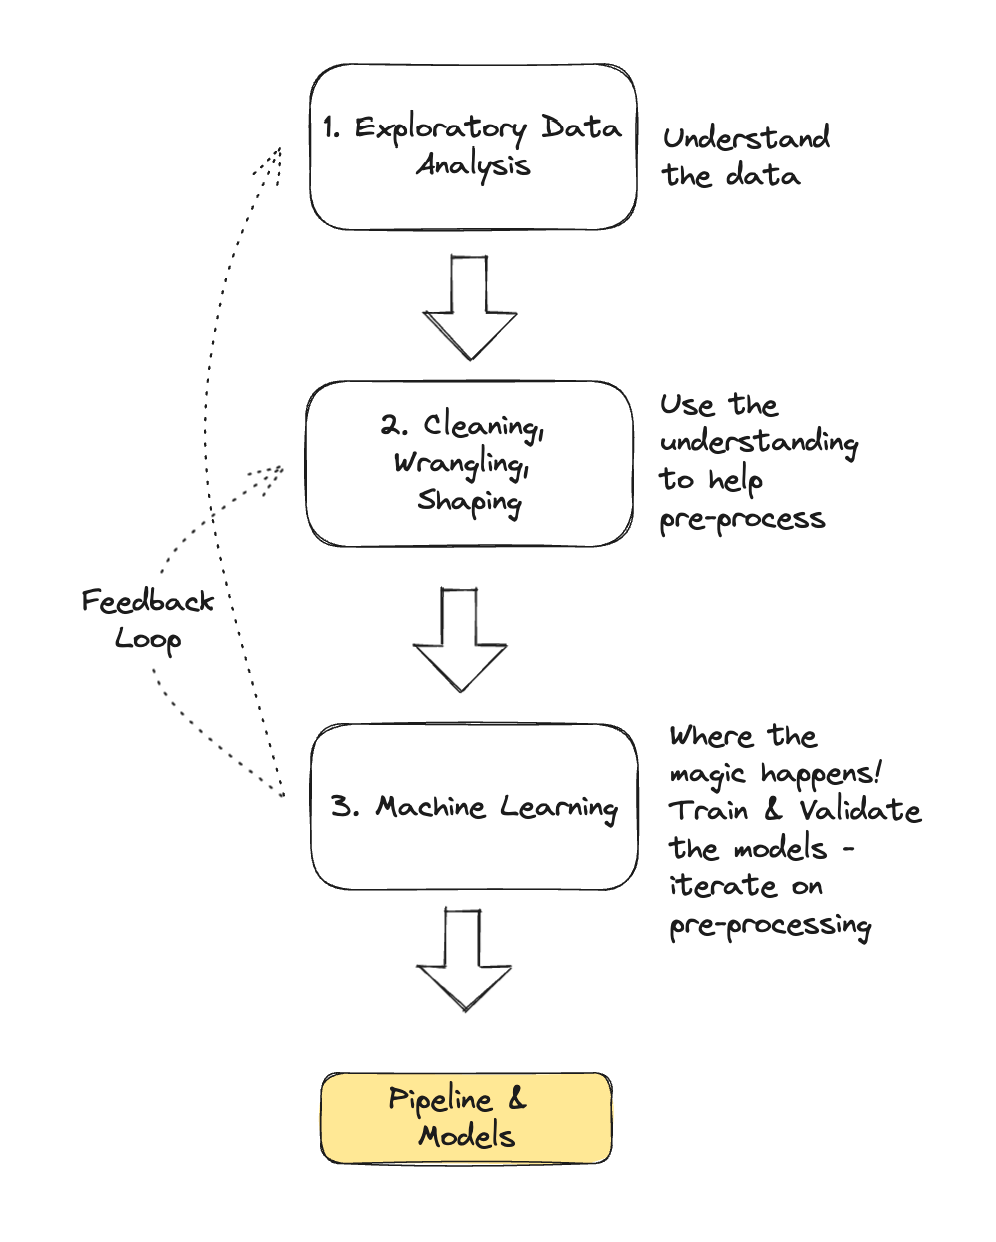

You can spend considerable time understanding the data and how it was collected. Once you do this, you can then start to think about how you might preprocess the data to get it into a shape for the ML algorithms. 

Note that there is a feedback loop in the process. Subsequent analysis of the models, and the features they find important can re-inform knowledge regarding the data set (taking you back into EDA). 

The pipeline can be used to preprocess new data, ensuring it is in the right shape for the model at inference time.

# Task 1: Exploratory Data Analysis (EDA)

## Quick Data Exploration

In [3]:
df.head(5)

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [4]:
df.tail(5)

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

Let's describe the features we have, their meaning and whether or not we have missing values.

| Name       | Description                                                                                                   | Type        | Integer Type (and potential for encoding) | Missing Values |
|------------|---------------------------------------------------------------------------------------------------------------|-------------|------------------------------------------|----------------|
| job        | type of job ("admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services") | Categorical | OneShot                                        | 10             |
| marital    | marital status ("married", "divorced", "single"; note: "divorced" means divorced or widowed)                  | Categorical | OneShot                                        | 0              |
| education  | education level ("unknown", "secondary", "primary", "tertiary")                                                | Categorical | OneShot or Could be encoded to ordinal             | 104            |
| default    | has credit in default?                                                                                        | Categorical | Can be encoded to binary                 | 0              |
| housing    | has housing loan?                                                                                             | Categorical | Can be encoded to binary                 | 0              |
| loan       | has personal loan?                                                                                            | Categorical | Can be encoded to binary                 | 0              |
| contact    | contact communication type                                                                                    | Categorical | OneShot                                        | 191            |
| month      | last contact month of year                                                                                    | Categorical | OneShot or Cyclical, probably OneShot in this use case though                                        | 0              |
| poutcome   | outcome of the previous marketing campaign ("failure", "nonexistent", "success")                              | Categorical | OneShot                                        | 454            |
| age        | Age                                                                                                           | Numerical   | Ordinal                                  | 12             |
| balance    | average yearly balance                                                                                        | Numerical   | Ordinal                                  | 0              |
| day        | last contact day of the month                                                                                 | Numerical   | Ordinal                                  | 0              |
| duration   | last contact duration, in seconds                                                                             | Numerical   | Ordinal                                  | 0              |
| campaign   | number of contacts performed during this campaign and for this client                                         | Numerical   | Ordinal                                  | 0              |
| pdays      | number of days that passed by after the client was last contacted from a previous campaign (-1 means client was never contacted)                   | Numerical   | Ordinal                                  | 0              |
| previous   | number of contacts performed before this campaign and for this client                                         | Numerical   | Ordinal                                  | 0              |
| subscribed | has the client subscribed a term deposit?                                                                     | Categorical | Binary (Target variable)                                        | 0              |


Note: The 'Missing Values' column indicates the number of missing entries for each feature based on the provided dataset information and typical data analysis practices. This table integrates both the types of data and a practical insight into the data's completeness.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1988 non-null   float64
 1   job         1990 non-null   object 
 2   marital     2000 non-null   object 
 3   education   1896 non-null   object 
 4   default     2000 non-null   object 
 5   balance     2000 non-null   int64  
 6   housing     2000 non-null   object 
 7   loan        2000 non-null   object 
 8   contact     1809 non-null   object 
 9   day         2000 non-null   int64  
 10  month       2000 non-null   object 
 11  duration    2000 non-null   int64  
 12  campaign    2000 non-null   int64  
 13  pdays       2000 non-null   int64  
 14  previous    2000 non-null   int64  
 15  poutcome    1546 non-null   object 
 16  subscribed  2000 non-null   object 
dtypes: float64(1), int64(6), object(10)
memory usage: 265.8+ KB


In [6]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [7]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'subscribed'],
      dtype='object')

### Identify Missing data

In [8]:
missing_data = df.isnull().sum()
missing_data

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

Determine missing data as a ratio against the total number of rows. Filter out zeros and show as percentage.

In [9]:
missing_data = missing_data[missing_data > 0]
missing_data = missing_data / df.shape[0] * 100
missing_data

age           0.60
job           0.50
education     5.20
contact       9.55
poutcome     22.70
dtype: float64

- Nearly 23% of poutcomes are missing. This is a significant amount of missing data. Future data collection should seek to address this. As we will see later, there is a correlation between pdays=-1 and the missing poutcomes.
- Approx. 10% of contact details info is missing (i.e. contacted on telephone or mobile). It is more likely that mobiles are more prevalent today. Probably not a big deal int his use case.
- Approx. 5% of education data is missing. We can impute with 'unknwown'.
- < 1% of missing data for Age and Job. We can fill this with a mean value for age and an 'unknown' category for Job.

## Numerical Data Review

### Quick Examination of Numerical Attributes
Here are the descriptive statistics for the numerical columns in the dataset:

In [10]:
descriptive_stats = df.describe(include='all')
descriptive_stats

age         job  marital  education default       balance  \
count   1988.000000        1990     2000       1896    2000   2000.000000   
unique          NaN          11        3          3       2           NaN   
top             NaN  management  married  secondary      no           NaN   
freq            NaN         461     1111        995    1985           NaN   
mean      41.753018         NaN      NaN        NaN     NaN   1413.663500   
std       12.724358         NaN      NaN        NaN     NaN   3131.224213   
min       18.000000         NaN      NaN        NaN     NaN   -980.000000   
25%       32.000000         NaN      NaN        NaN     NaN    201.500000   
50%       38.000000         NaN      NaN        NaN     NaN    551.000000   
75%       50.000000         NaN      NaN        NaN     NaN   1644.500000   
max       93.000000         NaN      NaN        NaN     NaN  81204.000000   

       housing  loan   contact          day month     duration     campaign  \
count     2000  2000      1809  2000.000000  2000  2000.000000  2000.000000   
unique       2     2         2          NaN    12          NaN          NaN   
top         no    no  cellular          NaN   feb          NaN          NaN   
freq      1037  1750      1663          NaN   404          NaN          NaN   
mean       NaN   NaN       NaN    13.851500   NaN   292.020500     1.909500   
std        NaN   NaN       NaN     9.712189   NaN   221.557295     1.378862   
min        NaN   NaN       NaN     1.000000   NaN     7.000000     1.000000   
25%        NaN   NaN       NaN     5.000000   NaN   146.000000     1.000000   
50%        NaN   NaN       NaN    12.000000   NaN   236.000000     1.000000   
75%        NaN   NaN       NaN    23.000000   NaN   379.000000     2.000000   
max        NaN   NaN       NaN    31.000000   NaN  1823.000000    11.000000   

              pdays     previous poutcome subscribed  
count   2000.000000  2000.000000     1546       2000  
unique          NaN          NaN        3          2  
top             NaN          NaN  failure         no  
freq            NaN          NaN      955       1000  
mean     167.896000     2.561500      NaN        NaN  
std      131.754126     3.400735      NaN        NaN  
min       -1.000000     0.000000      NaN        NaN  
25%       75.750000     1.000000      NaN        NaN  
50%      182.000000     2.000000      NaN        NaN  
75%      251.000000     3.000000      NaN        NaN  
max      854.000000    55.000000      NaN        NaN

Generate histograms for numeric features to understand distributions

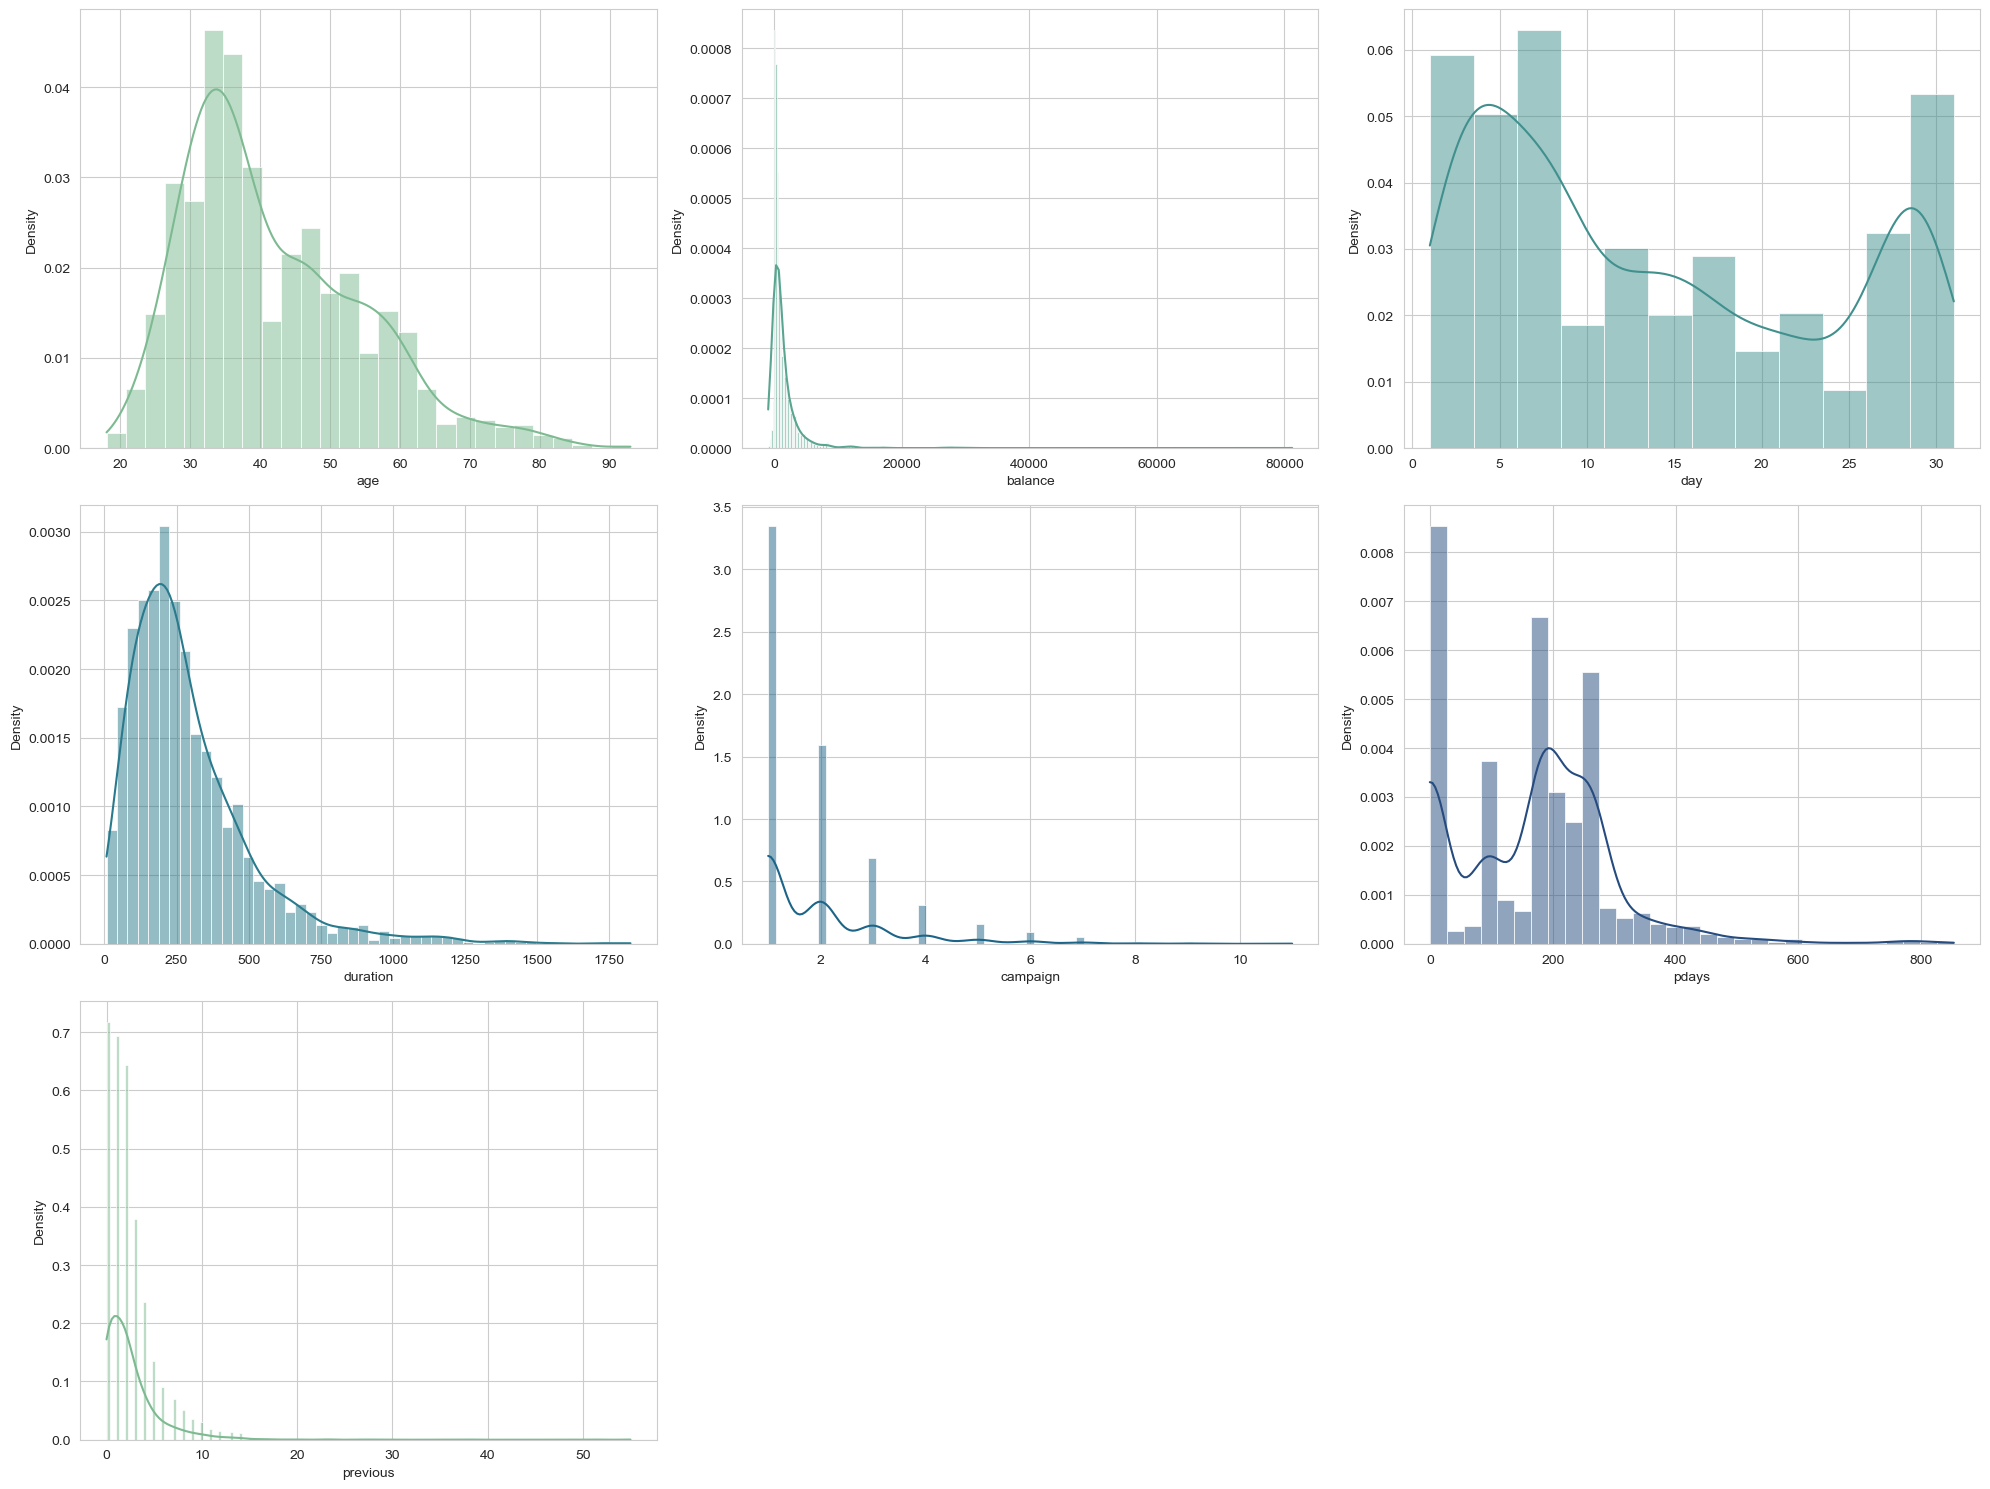

In [11]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
hist_palette = sns.color_palette(current_palette, n_colors=len(numeric_features))

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, stat="density", linewidth=0.5, color=hist_palette[i-1])
    plt.tight_layout()

plt.show()

The histograms provided represent the distribution of values across the numerical variables. Here's a summary of conclusions based on each histogram:

1. **Age**: The age distribution is right-skewed, with a majority of the subjects being between approximately 25 and 60 years old. There are fewer potential clients as the age increases beyond 60.

2. **Balance**: This histogram is highly skewed to the right, with most subjects having a balance close to 0. There are a few subjects with a significantly higher balance, but these are outliers in comparison to the majority.

3. **Day**: The day histogram shows that there are peaks in the distribution, suggesting that there might be specific days when the number sof calls is higher. There's a notable increase towards the end of the period captured, which could be indicative of a cyclical pattern (e.g., start or end of the month activities).

4. **Duration**: This variable is also right-skewed, with most events having a short duration and a few events having a very long duration (and these will correlate with higher age).

5. **Campaign**: This histogram indicates that most subjects were contacted a small number of times.

6. **Pdays**: The large spike at the left indicates a large number of subjects have a 'pdays' value of zero or near zero, suggesting that for most subjects, the number of days that passed by after the client was last contacted from a previous campaign is very low. The rest of the data suggests a long-tail where few subjects have a high 'pdays' value.

7. **Previous**: Similar to 'pdays', the 'previous' variable histogram shows a large number of subjects with a value of zero, indicating that most subjects were not contacted previously. There's a sharp drop as the number increases, which signifies very few subjects have been contacted multiple times.

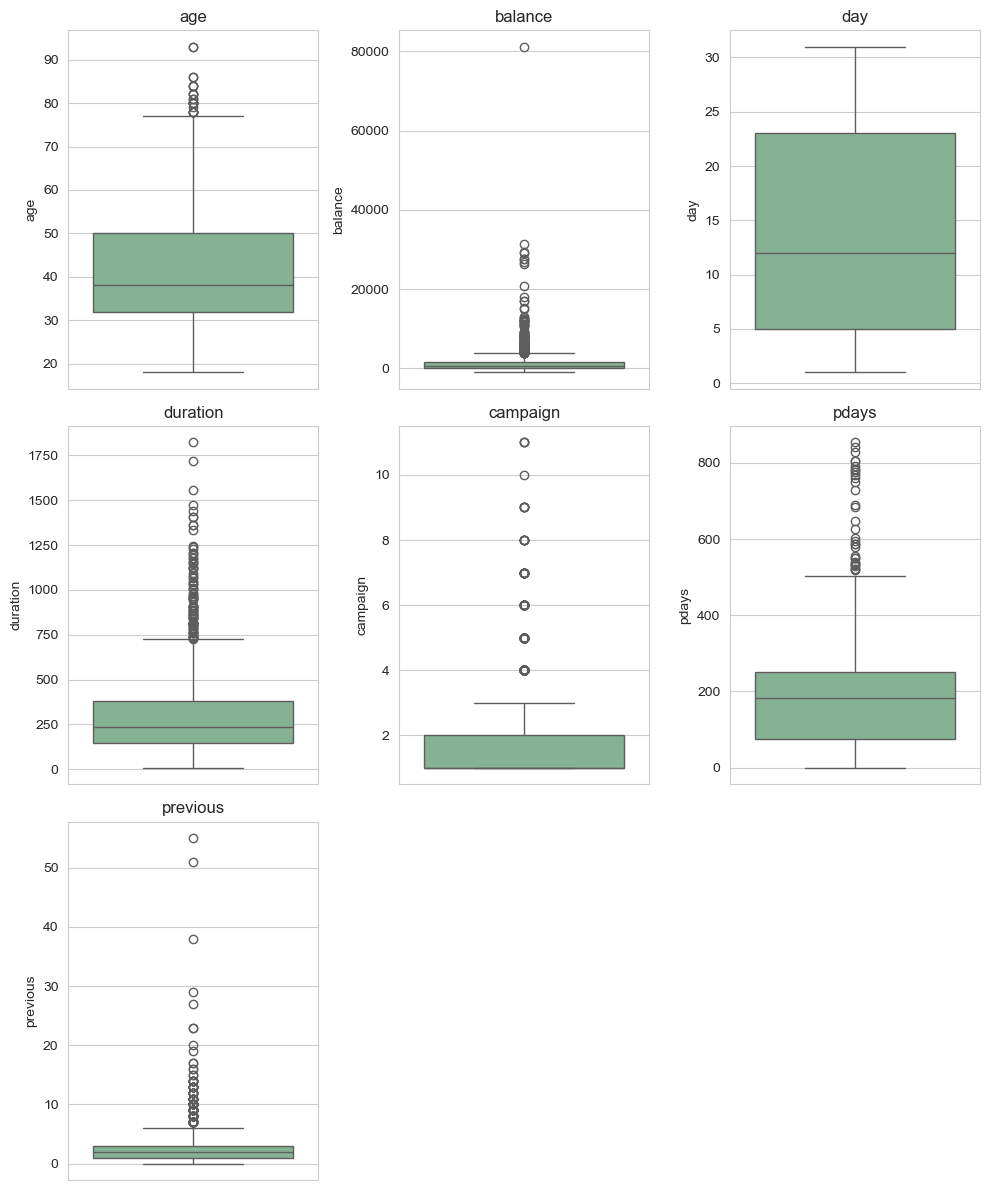

In [12]:
plt.figure(figsize=(10, 12))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

The above represents the boxplots for the numerical variables in the data. Here is a summary:

1. **Age**: The age distribution seems to be right-skewed with a few outliers on the higher end. The median age is around the late-30s to early 40s. The boxplot indicates a relatively young age profile within the dataset with most data falling below the age of 50.

2. **Balance**: The balance distribution is highly skewed to the right, with many outliers showing very high balances compared to the median. The median balance is quite low compared to the maximum, suggesting that a majority have a lower balance with a few having exceptionally high balances.

3. **Duration**: Duration also shows a right-skewed distribution. The majority of calls durations are short, but there are some cases with very long durations, indicated by the outliers. The median duration is low.

4. **Campaign**: The number of contacts performed during this campaign for a client is concentrated at the lower end, with the box very close to the bottom and several outliers indicating a few cases with a high number of contacts.

5. **Day**: This variable shows a fairly symmetrical distribution, possibly indicating the day of the month contacts were made. There are no apparent outliers, and the median is around the middle of the month.

6. **Pdays**: This variable shows a highly skewed distribution with a lot of outliers. Since 'pdays' represents the number of days that passed by after the client was last contacted from a previous campaign, the clustering at the lower end of the scale with a median very close to zero suggests that many clients were contacted recently or not at all since the previous campaign.

7. **Previous**: The 'previous' variable, indicating the number of contacts performed before this campaign, shows that most values are concentrated at 0, with a very small interquartile range and many outliers. This indicates that most clients had not been contacted or had very few contacts before the current campaign.

Overall, these plots suggest that the majority of the individuals in this dataset have:

- lower balances, 
- are relatively younger, 
- have been contacted for shorter durations, 
- have not been contacted frequently in this or previous campaigns, and a significant proportion were contacted quite recently before the current data was collected. 

The presence of outliers in several variables indicates that there are exceptions to these patterns which may be of interest, particularly if those outliers represent significant or influential cases in the dataset (e.g. high-value clients).

It is also possible to calculate skewness and kurtosis for the numerical columns

In [13]:
skewness = df.skew(numeric_only=True)
kurtosis = df.kurtosis(numeric_only=True)

skewness_kurtosis = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})
skewness_kurtosis

Skewness    Kurtosis
age        0.853921    0.390934
balance   11.461564  231.856074
day        0.403661   -1.285034
duration   2.045787    6.297587
campaign   2.320856    7.162811
pdays      0.920006    2.710735
previous   5.461168   59.746704

[Skewness](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/skewness) measures the asymmetry of the distribution of values. A skewness value:

| Value            | Implication                                |
|------------------|--------------------------------------------|
| Close to 0       | Indicates a *symmetrical distribution*.    |
| Greater than 0   | Indicates a distribution that is *skewed to the right* (tail extends towards more positive values). |
| Less than 0      | Indicates a distribution that is *skewed to the left* (tail extends towards more negative values). |


[Kurtosis](https://www.sciencedirect.com/topics/neuroscience/kurtosis) measures the "tailedness" of the distribution.

| Value            | Implication                                                                                      |
|------------------|--------------------------------------------------------------------------------------------------|
| Close to 0       | Indicates a distribution with tails similar to the normal distribution.                          |
| Greater than 0   | Indicates a distribution with heavier tails than the normal distribution, which means it has a higher peak and fatter tails, leading to a higher probability of extreme values. |
| Less than 0      | Indicates a distribution with lighter tails than the normal distribution, implying a lower peak and thinner tails, suggesting a lower probability of extreme values. |


With the above in mind, here we have:

- `Balance`, `duration`, `campaign`, and `previous` have *high skewness*, indicating that their distributions are significantly skewed to the right.
- `Balance` and `previous` have extremely *high kurtosis* values, suggesting that these features have heavy tails and are prone to outliers. This might necessitate data transformation or outlier treatment.
- `Day` has a slightly negative kurtosis, indicating lighter tails than the normal distribution, which is less of a concern here.

In [14]:
pdays_minus1 = df[df['pdays'] == -1].shape[0]

print(f"Number of clients that have not been contacted before: {pdays_minus1}")

Number of clients that have not been contacted before: 454


### Correlation of numerical data

<Axes: >

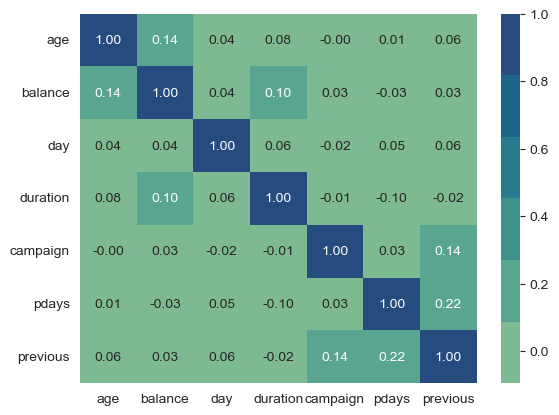

In [15]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.color_palette()   )

The heatmap represents the correlation matrix of numerical variables: age, balance, day, duration, campaign, pdays (days passed), and previous (contacts). Here's a summary of the conclusions we can draw from this heatmap:

1. **Strong Positive Correlation:** Each variable is perfectly correlated with itself (correlation coefficient = 1), which is shown by the red squares on the diagonal line. This is expected and can be ignored.

2. **Weak Correlation:** Most pairs of variables display very weak correlations, both positive and negative, as indicated by the correlation coefficients close to zero. This suggests that, overall, there are no strong linear relationships between these pairs (see next point).

3. **Moderate Positive Correlation:** There's a moderately positive correlation between `pdays` and `previous` (correlation coefficient ~0.22), which *might* indicate that if more days have passed since the last contact, there have been more contacts in the past. This seems to be the strongest (non-self) correlation visible on the heatmap.

4. **No Strong Negative Correlation:** There are no strong negative correlations present (close to -1). The strongest negative correlation is between 'duration' and 'pdays' (correlation coefficient ~-0.10), but it's still quite weak.

5. **Balance and Age Correlation:** There is a slight positive correlation between 'balance' and 'age' (correlation coefficient ~0.14), which could suggest that as clients get older, they might have slightly higher balances.

6. **Data Distribution Insight:** The presence of weak correlations suggests that there may not be strong individual predictors among these variables.

The lack of obvious, strong correlations means I *may* need more complex features (and perhaps a non-linear model later on - see appendix for SVM with RBF).

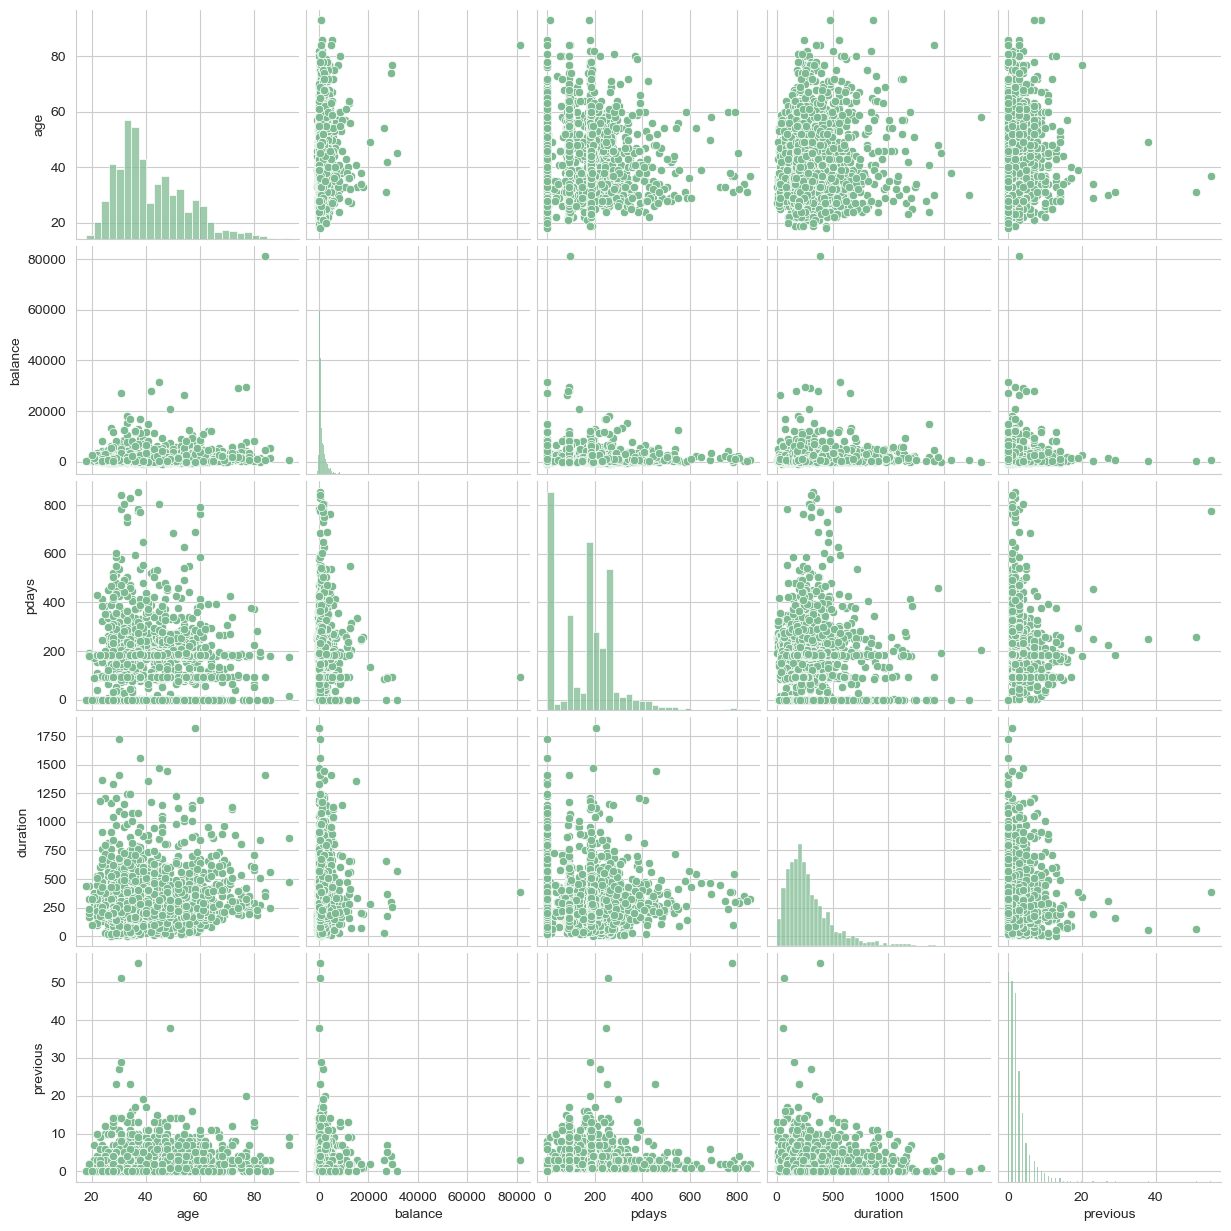

In [16]:
sns.pairplot(data=df[['age','balance','pdays','duration','previous']].dropna())
plt.show()

The pairwise plot, or pairs plot, provides a view of relationships between the selected numerical variables in a dataset. 

- **Histograms**: The diagonal shows histograms for each variable, allowing us to see the distribution of individual features. The histograms for `age`, `balance`, `duration`, `pdays`, and `previous` suggest right-skewed distributions, as the bulk of the data is concentrated on the left with a long tail to the right. 

- **Scatter Plots**: The off-diagonal elements are scatter plots for pairs of these variables, which give insight into the correlation and type of relationship between the variables.
    - `age` and `balance` do not show a clear linear relationship, suggesting that age may not be a strong predictor of account balance.
    - `age` and `duration` appear to have no strong correlation, as the data points are widely scattered.
    - For `balance` and `duration`, there are some outliers with high balances and long durations, but most data points are clustered near the origin. Those balance outliers are common to nearly all other attributes, suggesting independence.
    - `pdays` and `previous` show some degree of positive correlation; clients contacted more frequently in the past seem to have a shorter number of days since their last contact.
    - There are dense clusters near the origin for pairs involving `balance`, `duration`, `pdays`, and `previous`, suggesting that high values are rare.
    - The `balance` variable has several extreme outliers, as indicated by points far from the main cluster.

- **Distribution and Outliers**: The presence of outliers is particularly noticeable in the `balance` feature, which has extreme values far from the majority of the data points.

- **Correlation Strength**: The scatter plots do not show strong linear patterns between pairs of variables, implying that relationships, if any, might be nonlinear or that there might be no significant relationship at all.

This pairs plot provides an initial overview, and more detailed statistical analysis would be needed to draw concrete conclusions about the relationships and potential predictive power of these variables. 

This pairs plot highlights the importance of addressing outliers and considering transformations for skewed data before further analysis or modeling. This may come into play in Task 2: Data Preparation.

## Categorical Data Review

Here I will plot the distribution of the various categorical features, replacing the missing cells with unknown, where appropriate. 

In [17]:
# Replace missing values with 'unknown' for these columns
for col in categorical_columns:
    df[col].fillna('unknown', inplace=True)

# Check if there are any missing values left in these columns
missing_values_check = df[categorical_columns].isnull().sum()
missing_values_check

job           0
marital       0
education     0
default       0
housing       0
loan          0
contact       0
month         0
poutcome      0
subscribed    0
dtype: int64

Now we can plot all categories and get a sense of what is missing - plus there's no need to throw out rows with this missing data.

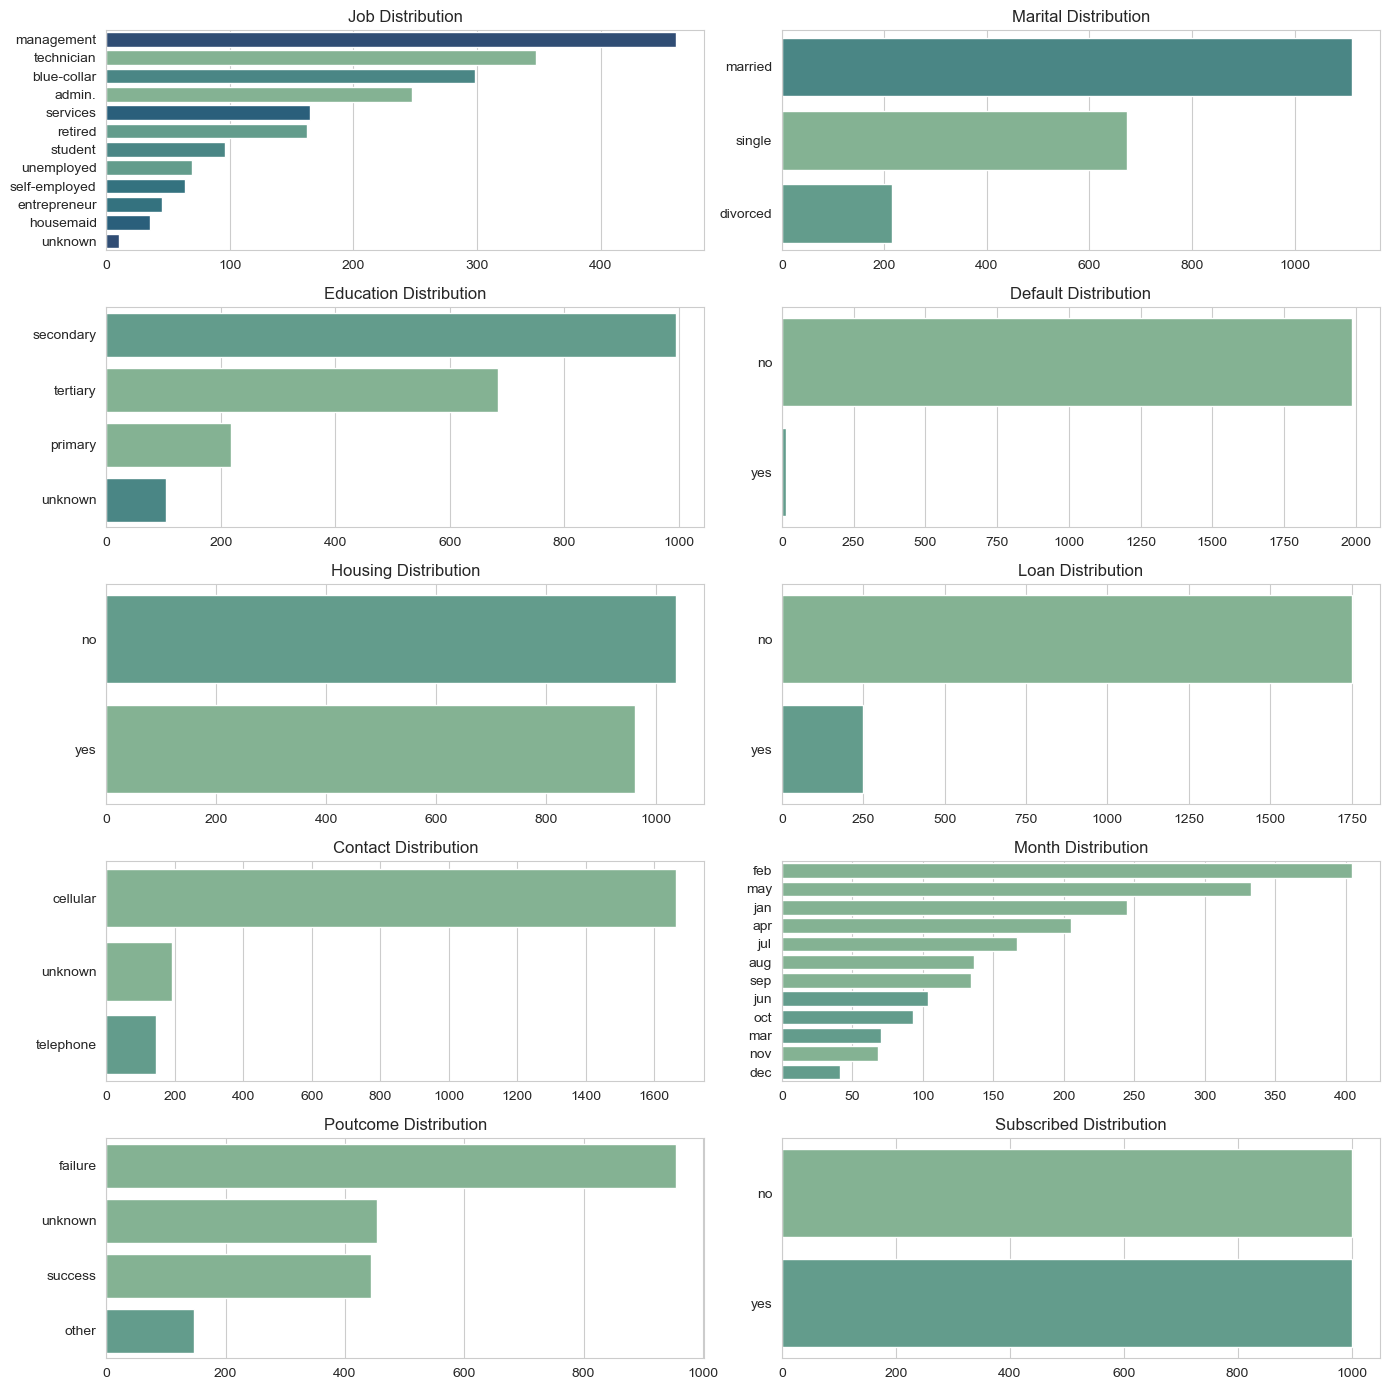

In [18]:
# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(14, 14))
axs = axs.flatten()  # Flatten the axis array for easier indexing

for i, category in enumerate(categorical_columns):
    current_palette = sns.color_palette(current_palette, len(df[category].unique()))
    sns.countplot(y=category, data=df, ax=axs[i], order=df[category].value_counts().index, hue=df[category], palette=current_palette)

    axs[i].set_title(f'{category.capitalize()} Distribution')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

The previous count plots represent the distribution of various categorical variables from the bank dataset.

1. **Job Distribution**: Most clients are listed under "management", "blue-collar", and "technician" job categories, with very few in the "unknown" category.

2. **Marital Distribution**: The "married" category has the highest count, followed by "single" and "divorced".

3. **Education Distribution**: Most clients have "secondary" education, followed by "tertiary", and fewer in "primary" and "unknown" education levels.

4. **Housing Distribution**: The breakdown between having a housing loan and not having one is nearly 50/50.

5. **Default Distribution**: Very few clients have credit in default.

6. **Loan Distribution**: Similar to Default, a smaller number of clients have personal loans.

7. **Contact Distribution**: "Cellular" is the most common method of contact, with "telephone" being less common and a small portion categorised as "unknown".

8. **Month Distribution**: The distribution over months shows that some months (like May, July, August, and June) have noticeably higher counts, suggesting these are more active months for contacting clients.

9. **Poutcome Distribution**: The outcome of previous marketing campaigns is mostly "failure", with "unknown" and "success" being the next most common and other being the least common.

10. **Subscribed Distribution**: The breakdown between subcribed and not subscribed is roughly 50/50.



 ## Mixing Numerical and Categorical 

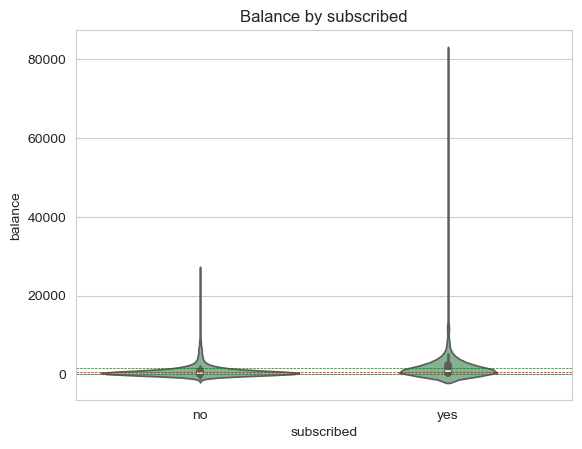

In [19]:
sns.violinplot(data=df, x='subscribed', y='balance')

plt.axhline(df['balance'].median(), color='r', linestyle='dashed', linewidth=0.5)
plt.axhline(df['balance'].quantile(0.75), color='g', linestyle='dashed', linewidth=0.5)
plt.axhline(df['balance'].quantile(0.25), color='g', linestyle='dashed', linewidth=0.5)
plt.title('Balance by subscribed')
plt.show()

Here's what we can infer from these violin plots:

- **Width:** The width of the violin at different balance levels indicates the density of data points at that level. A wider section means more customers fall into that balance bracket.
- **Skewness:** Both distributions are right-skewed, which is indicated by the long tail extending towards the higher balance values (we tackle this in task 2). This suggests a small number of customers with very high balances compared to the majority.
- **Comparison of Medians:** The white dots represent the median balance for each group. It appears that the median balance for customers who have subscribed is slightly higher than for those who have not.
- **Comparison of Quartiles:** The thick bar within the violins indicates the interquartile range (IQR). The IQR seems to be similar for both groups, though it's slightly longer for subscribers, suggesting more variability in the balance of subscribers.
- **Presence of Outliers:** The long vertical lines (whiskers) extending from the violins suggest the presence of outliers (for high and low balances - in general, the medians are close). 

The plot suggests that having a higher balance *might* be associated with a greater likelihood of subscription, but the effect is not straightforward as there is considerable overlap in the balance distributions of subscribers and non-subscribers. **Furthermore, the presence of significant outliers indicates that balance alone may not be a definitive predictor of subscription status. There are potentially other factors like previous subscription, month, duration etc... to consider**

### Normalise the Balance and re-plot
Normalise the balance (given some user's balances are zero or negative) and replot to see how the violin plots compare. Because some of the balance values are negative or zero I will:

- Find the minimum value in the 'balance' column
- If the minimum value is 0 or negative, shift all the data by adding (1 - min_balance)
- Apply the log transformation to only positive values

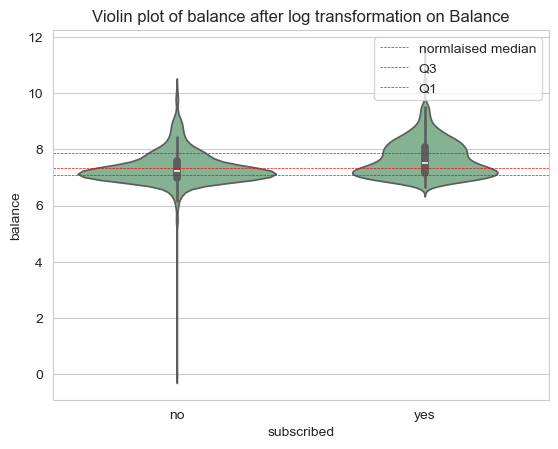

In [20]:
df_normalise_balance = df.copy()

min_balance = df_normalise_balance['balance'].min()
df_normalise_balance['balance'] += (1 - min_balance)
df_normalise_balance['balance'] = np.log(df_normalise_balance['balance'])

sns.violinplot(data=df_normalise_balance, x='subscribed', y='balance')

plt.axhline(df_normalise_balance['balance'].median(), color='r', linestyle='dashed', linewidth=0.5, label='normlaised median')
plt.axhline(df_normalise_balance['balance'].quantile(0.75), color='g', linestyle='dashed', linewidth=0.5, label='Q3')
plt.axhline(df_normalise_balance['balance'].quantile(0.25), color='g', linestyle='dashed', linewidth=0.5, label='Q1')
plt.legend()


plt.title('Violin plot of balance after log transformation on Balance')
plt.show()

Here I compare the distribution of normalised balances (after a logarithmic transformation) between two groups: those who have not subscribed ("no") and those who have ("yes"). 

We can see:

- Both groups have a similar median balance as indicated by the white dot within the thick black bar at the center of each distribution.
- The distribution of balances for both groups is wide, suggesting variability in the financial status among the individuals in each group.
- The violin for non-subscribers is slightly wider at the lower balance range, suggesting a higher density of individuals with lower balances who have not subscribed.
- The distribution of balances for those who have subscribed appears slightly skewed towards higher balances, indicating subscribers might generally have higher balances compared to non-subscribers.

These observations suggest that while the median balance between the groups is similar, the spread and skewness of the balance distribution differ slightly, with a *potential* trend towards higher balances among subscribers. This is TBD.

Looking at a plot of Jobs verses Subscription success.

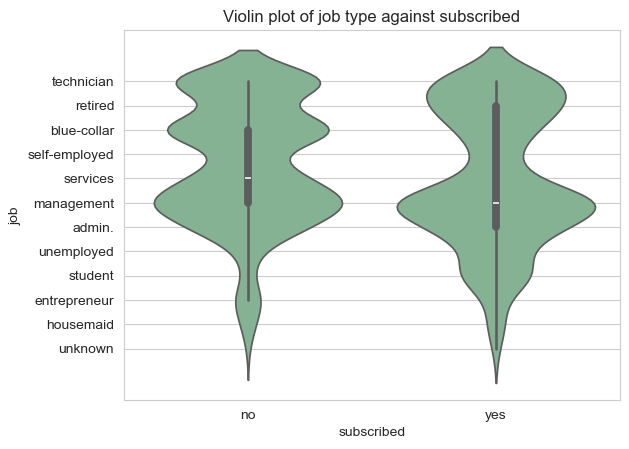

In [21]:
sns.violinplot(data=df, x='subscribed', y='job')
plt.title('Violin plot of job type against subscribed')
plt.show()

Looking at a violin plot of Age verses subscription success.

Text(0.5, 1.0, 'Violin plot of age against subscribed')

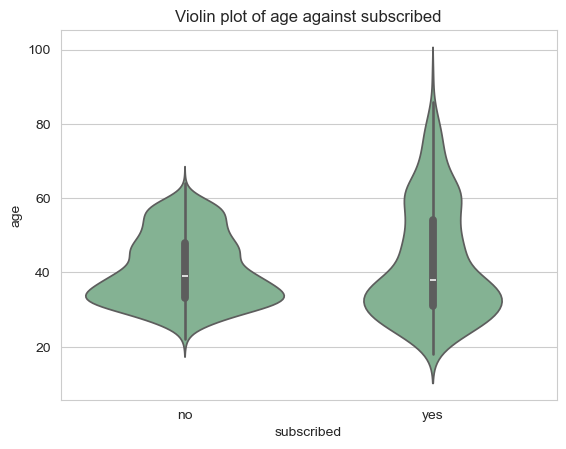

In [22]:
sns.violinplot(data=df, x='subscribed', y='age')
plt.title('Violin plot of age against subscribed')

From this plot, we can see that:

- Both subscriber groups ("no" and "yes") have a similar median age. The age distribution for both groups covers a wide range, from young adults to seniors, but the median ages are indeed quite close to each other.
- The spread of ages among subscribers is wider, showing more variability in the ages of subscribers compared to non-subscribers.

This suggests that while there is a variety of ages among both subscribers and non-subscribers, the central tendency (median age) is similar between the two groups.

## The Questions

Given the previous EDA I have the following questions. I'll probably only answer a subset.

1. How does a previous failure to subscribe impact the last campaign outcome
2. Is there a correlation between pdays=-1 and poutcome=missing? That is, can I use some information I have to fill in missing data?
3. The initial review highlighted `Duration`, `Day` and `Balance` as having a strong correlation with the `subscribed` outcome. We have a lot of missing values and I would like to understand the impact of removing rows with missing data to see whether or not the patterns between the aforementioned variables and the target outcome are changed, with less data.
4. What impact does filtering out outliers have on the strongest observed correlations?
5. Does number of contacts per person correlate with success in successful subscriptions?
6. How does age bracket impact the decision to subscribe?
7. Study the breakdown of people in the 0-61 and 61-100 age groups who subscribed. 

### Q1. How does a previous failure to subscribe impact the last campaign outcome?
Let's looks at the ratio between the poutcome counts and the subscription rate.

In [23]:
df_poutcome = df.groupby(['poutcome', 'subscribed']).size().unstack()
df_poutcome['percentage'] = (df_poutcome['yes'] / (df_poutcome['yes'] + df_poutcome['no'])) * 100

df_poutcome

subscribed   no  yes  percentage
poutcome                        
failure     788  167   17.486911
other        36  111   75.510204
success      10  434   97.747748
unknown     166  288   63.436123

Here's a breakdown relating a subscription based on the previous outcome:

1. **Failure**: We had a 17.49% success rate of subscription among the individuals with a previous 'failure'. So, if you didn't subscribe on the previous campaing, then you are more likely to not subscribe in this campaign.

2. **Success**: If you subscribed in a previous campaing then you are 97.7% more likely to resubscribe again.
3. **Other**: You are 75.5% more likely to subscribe if this is your first campaign
4. **Unknown**: 454 of the rows are missing this data.

**This suggests the potential effectiveness of a marketing campaign that encourages individuals to resubscribe.** But it is worth noting that we have a large number of missing poutcome data (454 to be exact) data that may be significant. See next question.

### Q2. is there a correlation between pdays=-1 and the missing poutcome's

In [24]:
df_poutcome = df.groupby(['pdays', 'poutcome']).size().unstack()
df_poutcome

poutcome  failure  other  success  unknown
pdays                                     
-1            NaN    NaN      NaN    454.0
 1            1.0    NaN      6.0      NaN
 2            1.0    NaN      1.0      NaN
 4            NaN    NaN      1.0      NaN
 5            1.0    NaN      NaN      NaN
...           ...    ...      ...      ...
 804          1.0    NaN      NaN      NaN
 805          NaN    1.0      NaN      NaN
 828          1.0    NaN      NaN      NaN
 842          1.0    NaN      NaN      NaN
 854          1.0    NaN      NaN      NaN

[363 rows x 4 columns]

Yes, there is. Looks like the missing poutcome data should be tagged as 'other' (as there's a direct correlation between -1 and the missing entries for poutcome).Let's do this in task 2.

In [25]:
df_fix_missing_poutcomes = df.copy()

df_fix_missing_poutcomes.loc[df['pdays'] == -1, 'poutcome'] = 'other'

df_poutcome = df_fix_missing_poutcomes.groupby(['poutcome', 'subscribed']).size().unstack()
df_poutcome['percentage'] = (df_poutcome['yes'] / (df_poutcome['yes'] + df_poutcome['no'])) * 100

df_poutcome

subscribed   no  yes  percentage
poutcome                        
failure     788  167   17.486911
other       202  399   66.389351
success      10  434   97.747748

### Q3. Understand the impact of removing rows with missing data on the distributions

In [26]:
df_dropped = df.dropna() #remove missing values
descriptive_stats_dropped = df_dropped.describe()

original_descriptive_stats = df.describe()

# show change in descriptive statistics
descriptive_stats_comparison = pd.concat([original_descriptive_stats, descriptive_stats_dropped], axis=1, keys=['Original', 'After Dropping Missing'])

descriptive_stats_comparison

Original                                                       \
               age       balance          day     duration     campaign   
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

                                After Dropping Missing                \
             pdays     previous                    age       balance   
count  2000.000000  2000.000000            1988.000000   1988.000000   
mean    167.896000     2.561500              41.753018   1416.237928   
std     131.754126     3.400735              12.724358   3139.691792   
min      -1.000000     0.000000              18.000000   -980.000000   
25%      75.750000     1.000000              32.000000    199.750000   
50%     182.000000     2.000000              38.000000    551.000000   
75%     251.000000     3.000000              50.000000   1644.500000   
max     854.000000    55.000000              93.000000  81204.000000   

                                                                        
               day     duration     campaign        pdays     previous  
count  1988.000000  1988.000000  1988.000000  1988.000000  1988.000000  
mean     13.820926   292.057344     1.903924   167.853119     2.563380  
std       9.697183   221.842129     1.363971   132.048849     3.408522  
min       1.000000     7.000000     1.000000    -1.000000     0.000000  
25%       5.000000   146.000000     1.000000    75.000000     1.000000  
50%      12.000000   236.000000     1.000000   182.000000     2.000000  
75%      23.000000   375.250000     2.000000   251.000000     3.000000  
max      31.000000  1823.000000    11.000000   854.000000    55.000000

Plot the comparison of descriptive statistics before and after dropping missing values (cover all values) - does the distribution change?

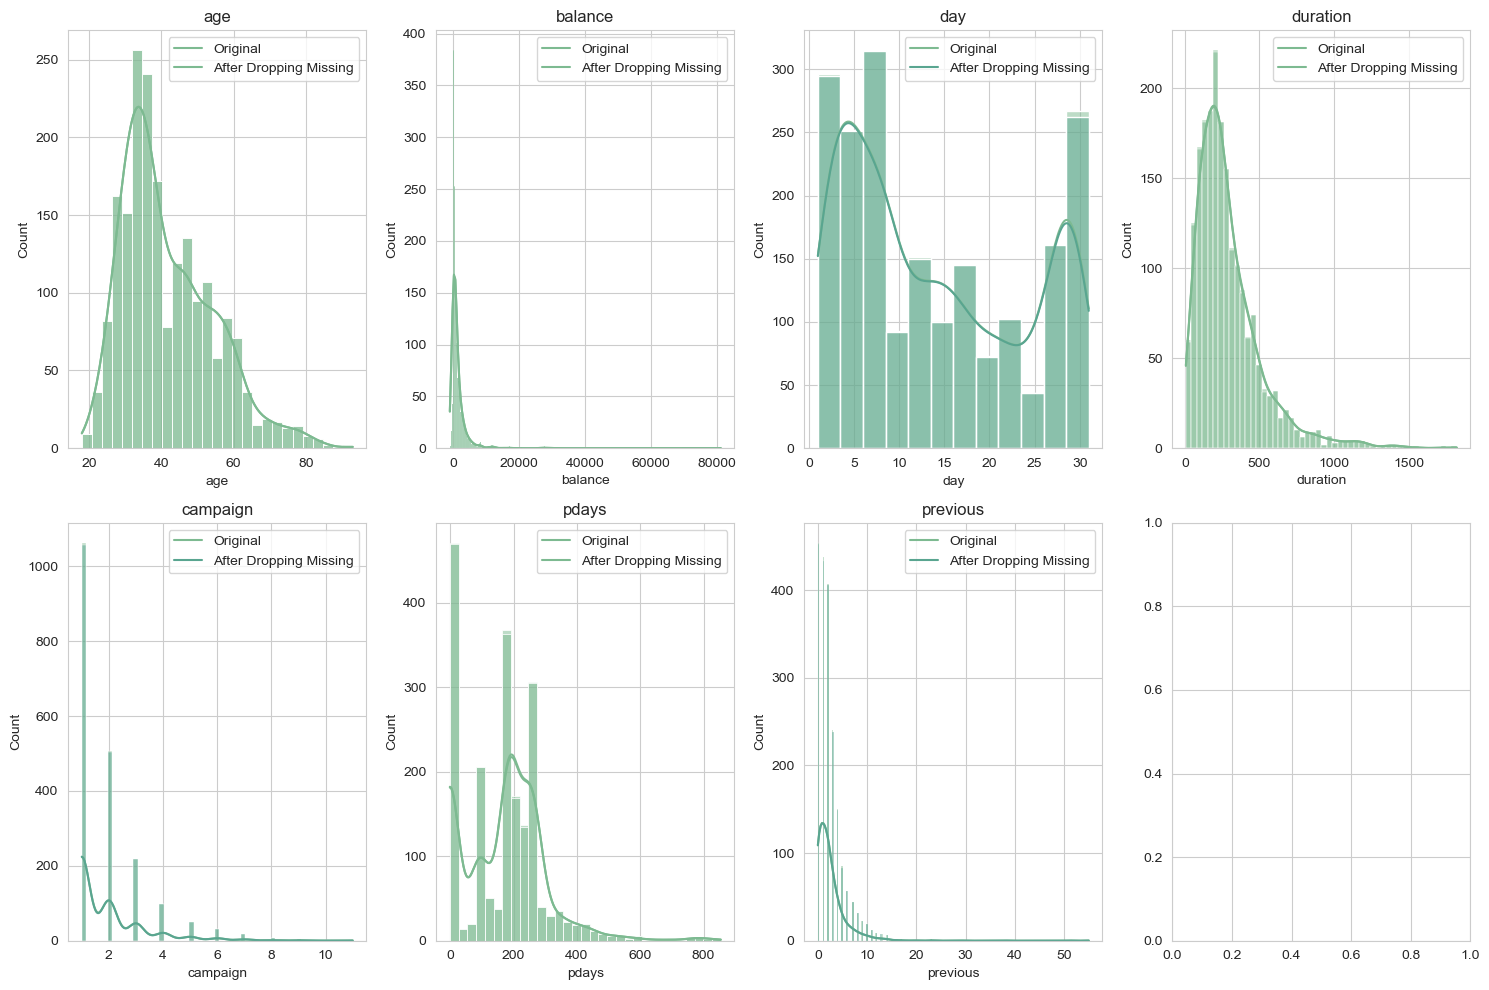

In [27]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
hist_palette = sns.color_palette(current_palette, n_colors=len(numeric_features))

fig, axes = plt.subplots(2, 4, figsize=(15, 10))

axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(df[numeric_features]):
    sns.histplot(df[c], kde=True, ax=axes[i])
    sns.histplot(df_dropped[c], kde=True, ax=axes[i], color=hist_palette[i-1])
    axes[i].set_title(c)
   
    axes[i].legend(['Original', 'After Dropping Missing'])

plt.tight_layout()
plt.show()

So, I can see that removing the missing data reduces the counts but does not massively change the distribution of counts. Having said this, I would rather fill-in the missing data than remove rows that have missing data (who knows what useful information we are throwing out).

### Q4. What impact does filtering out outliers have on the strongest observed correlations?
See task 2

### Q5. Does number of contacts correlate with success in successful subscriptions? 

In [28]:
df_campaign_analysis = df.copy()

df_campaign_analysis['subscribed'] = df_campaign_analysis['subscribed'].map({'yes': 1, 'no': 0})

campaign_effect = df_campaign_analysis.groupby('campaign')['subscribed'].agg(['count', 'sum']).reset_index()
campaign_effect['subscription_rate'] = campaign_effect['sum'] / campaign_effect['count'] * 100

campaign_effect.sort_values('campaign', inplace=True)

campaign_effect.head(10)

campaign  count  sum  subscription_rate
0         1   1063  542          50.987770
1         2    506  243          48.023715
2         3    219  123          56.164384
3         4     99   47          47.474747
4         5     50   20          40.000000
5         6     31   13          41.935484
6         7     17    5          29.411765
7         8      6    3          50.000000
8         9      5    2          40.000000
9        10      1    0           0.000000

Up to a point, yes. But it looks like the subscription rate peaks at the third call and after than it tends to drop off (perhaps repeated calls may be getting annoying?).

### Q6. How does age bracket impact the decision to subscribe?

Here I will create bins for age and balance. The reason for doing this is that it can be useful to group numeric values to understand behaviour over a range. This can allow you to spot trends more quickly instead of being distrated by individual values. In the next stage, I will ask a series of questions and use bins to helps answer it.

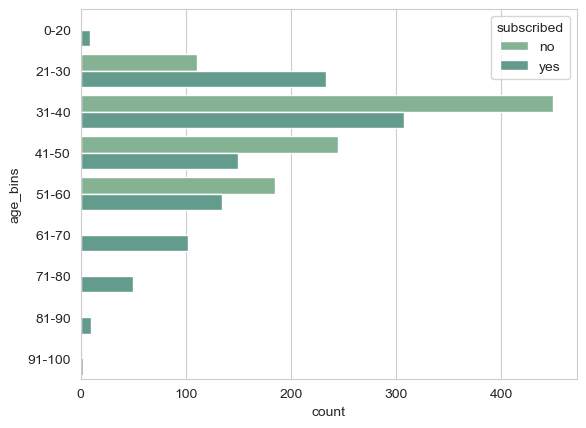

In [29]:
df_new_data = df.copy()
df_new_data['age_bins'] = pd.cut(df['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])
plot = sns.countplot(y='age_bins', hue='subscribed', data=df_new_data)

We can see that for age groups:

- `21-30` appear more ameanable to subscription, by a factor of 2.
- `31-40` show the most subscriptions. But, also the most rejections to subscription.
- `41-60` show a downward trend in rejections and subscriptions (but it's not zero)
- `60-100` appear more ameanble to subscription (with nothing like the numbers in the 31-40 age group though).

Here I sum up yes subscriptions for age range 0-60 and 61-100.

age_bins_split  subscribed
0-60            no            990
                yes           833
61-100          yes           164
                no              1
Name: subscribed, dtype: int64

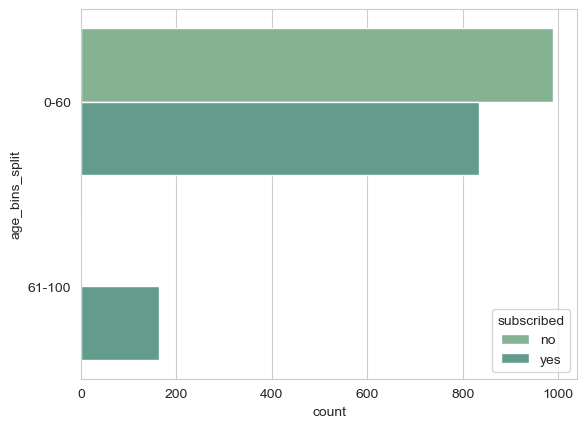

In [30]:
df_new_data['age_bins_split'] = pd.cut(df['age'], bins=[0, 60, 100], labels=['0-60', '61-100'])
sns.countplot(y='age_bins_split', hue='subscribed', data=df_new_data)

df_new_data.groupby('age_bins_split')['subscribed'].value_counts()

### Q7. Study the breakdown of people in the 0-61 and 61-100 age groups who subscribed

In [31]:
df_new_data.groupby('age_bins_split')['subscribed'].value_counts(normalize=True)

percentage_0_60_subscribed = 833/ (833 + 164) * 100
percentage_61_100_subscribed = 164 /(833 + 164) * 100

#print
percentage_0_60_subscribed, percentage_61_100_subscribed

(83.55065195586761, 16.449348044132396)

This tells us that:

- 83.6% of subscribers are in the age group 0-60
- 16.45% of subscribers are in the age group 61-100

# Task 2: Data Preparation
This exercise is typically referred as either *data preparation*, or *data preprocessing*, or *data munging*, or *data wrangling*.

The EDA phase identified some areas for us to tackle:

- Missing Values (we found a direct correlation between pdays=-1 and poutcome missing - let's fill that)
- The categorical variables need to be suitablly encoded
- Highly skewed data (e.g. balance)
- Outliers, particularly in the Balance field
- Fields that may need re-scaling.


**Goals:** Ensure that you have:

- Encoded all categorical attributes as numerical,
- Filled in all missing values,
- Applied a scaler to rescale features,
- Treated outliers and skewed attribute distribution appropriately,
- Created at least one new feature from the existing ones.
- Shortly describe and justify the data preparation choices you have made in markdown cells.

**Note:** I will walk through all of the main pre-processing steps and then show a pipeline-based approach that encompasses all of them in one neat workflow. The end result will be a csv that is suitable for use with an ML algorithm (like SVM). The appendix will show the use of this pipeline with some simple ML algorithms (just to make sure the pre-processing is doing what I think it should be doing).

In [32]:
df = pd.read_csv('bank.csv')

df_copy = df.copy() # Keep a backup

# Review descriptive stats - this will guide the pre-processing work
descriptive_stats = df.describe(include='all')
descriptive_stats

age         job  marital  education default       balance  \
count   1988.000000        1990     2000       1896    2000   2000.000000   
unique          NaN          11        3          3       2           NaN   
top             NaN  management  married  secondary      no           NaN   
freq            NaN         461     1111        995    1985           NaN   
mean      41.753018         NaN      NaN        NaN     NaN   1413.663500   
std       12.724358         NaN      NaN        NaN     NaN   3131.224213   
min       18.000000         NaN      NaN        NaN     NaN   -980.000000   
25%       32.000000         NaN      NaN        NaN     NaN    201.500000   
50%       38.000000         NaN      NaN        NaN     NaN    551.000000   
75%       50.000000         NaN      NaN        NaN     NaN   1644.500000   
max       93.000000         NaN      NaN        NaN     NaN  81204.000000   

       housing  loan   contact          day month     duration     campaign  \
count     2000  2000      1809  2000.000000  2000  2000.000000  2000.000000   
unique       2     2         2          NaN    12          NaN          NaN   
top         no    no  cellular          NaN   feb          NaN          NaN   
freq      1037  1750      1663          NaN   404          NaN          NaN   
mean       NaN   NaN       NaN    13.851500   NaN   292.020500     1.909500   
std        NaN   NaN       NaN     9.712189   NaN   221.557295     1.378862   
min        NaN   NaN       NaN     1.000000   NaN     7.000000     1.000000   
25%        NaN   NaN       NaN     5.000000   NaN   146.000000     1.000000   
50%        NaN   NaN       NaN    12.000000   NaN   236.000000     1.000000   
75%        NaN   NaN       NaN    23.000000   NaN   379.000000     2.000000   
max        NaN   NaN       NaN    31.000000   NaN  1823.000000    11.000000   

              pdays     previous poutcome subscribed  
count   2000.000000  2000.000000     1546       2000  
unique          NaN          NaN        3          2  
top             NaN          NaN  failure         no  
freq            NaN          NaN      955       1000  
mean     167.896000     2.561500      NaN        NaN  
std      131.754126     3.400735      NaN        NaN  
min       -1.000000     0.000000      NaN        NaN  
25%       75.750000     1.000000      NaN        NaN  
50%      182.000000     2.000000      NaN        NaN  
75%      251.000000     3.000000      NaN        NaN  
max      854.000000    55.000000      NaN        NaN

# Remove Duplicate or unneeded data

The bank dataset [notes](https://archive.ics.uci.edu/dataset/222/bank+marketing) suggested not using `duration` as a predictor as it is not known before the call is made and so is not useful as a predictor:

> last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Therefore, I will remove this column.

In [33]:
df.drop('duration', axis=1, inplace=True)
df.head(5)

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  campaign  pdays  previous poutcome subscribed  
0  cellular    1   apr         2    131         2  failure         no  
1  cellular    1   apr         2    133         1  failure         no  
2  cellular    1   apr         2    239         1  failure         no  
3  cellular    1   apr         1    238         2  failure         no  
4  cellular    1   apr         1    307         1  failure         no

## Handle Missing Values
### Missing Value Utility Functions

In [34]:
from sklearn.impute import SimpleImputer

def apply_simple_imputer(data_frame, column_name, strategy, fill_value=None):
    """
    Applies SimpleImputer to a specified column of a pandas DataFrame.
    """
    # Initialise the imputer based on the strategy
    if strategy == 'constant' and fill_value is not None:
        imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
    else:
        imputer = SimpleImputer(strategy=strategy)

    column = data_frame[[column_name]]          # Extract the column as a DataFrame to maintain a 2D structure

    imputed = imputer.fit_transform(column)     # Apply fit_transform on the extracted column

    data_frame[column_name] = imputed           # Replace the original column with the imputed data

def summarise_missing_data(data_frame):
    # Check for missing data in each column
    missing_data = data_frame.isnull().sum().reset_index()
    missing_data.columns = ['Column Name', 'Missing Values']
    
    # Keep only rows where there are missing values
    missing_data = missing_data[missing_data['Missing Values'] > 0]
    
    # Determine the type of each column (Numerical or Categorical)
    missing_data['Type'] = missing_data['Column Name'].apply(
        lambda x: 'Numerical' if pd.api.types.is_numeric_dtype(data_frame[x]) else 'Categorical'
    )

    return missing_data

### Show missing Values

In [35]:
missing_data_summary_df = summarise_missing_data(df)
missing_data_summary_df

Column Name  Missing Values         Type
0          age              12    Numerical
1          job              10  Categorical
3    education             104  Categorical
8      contact             191  Categorical
14    poutcome             454  Categorical

### Missing Numeric Features

#### Age

Here, I will use the median as the filler value. It is more robust and preferred if the data is skewed, as it is less influenced by outliers.

In [36]:
apply_simple_imputer(df, column_name='age', strategy='median')

### Missing Object Features
#### Job, Education, Contact
It is reasonable to fill these missing categorical columns with the 'unknown' label. Mainly, to highlight the lack of knowledge that may inform subsequent data gathering efforts. 

In [37]:
apply_simple_imputer(df, column_name='job', strategy='constant', fill_value='unknown')
apply_simple_imputer(df, column_name='education', strategy='constant', fill_value='unknown')
apply_simple_imputer(df, column_name='contact', strategy='constant', fill_value='unknown')

#### poutcome
The EDA phase shows that there's a direct correlation between the pdays and poutcome missing data. It is reasonable to assume that the missing poutcomes relate to the pdays being equal to -1. 

In [38]:
df.loc[df['pdays'] == -1, 'poutcome'] = 'other'

Re-check for missing values

In [39]:
missing_data_summary_df = summarise_missing_data(df)
missing_data_summary_df

Empty DataFrame
Columns: [Column Name, Missing Values, Type]
Index: []

All missing data has been resolved. The missing poutcome fields values have been mapped to 'other'.

## Encoding categorical attributes
We see that many of the features use strings to describe the data. This can be very useful in the exploratory phase as it makes it easy to interpret the data (i.e. it is human readable). However, eventually we will want to use machine learning algorithms to interact with this data. In this case, it is neccesary to ensure the data is in a format that is suitable for the ML algorithm.

Here I will binary and one-hot encode specified categorical variables (based on the range of values). I will also cyclically encode month and day.

First, let us list the variables we are interested in. 

In [40]:
categorical_variables = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_variables)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'subscribed']


Note, there are several types of categorical fields:

- 'job', 'marital', 'education', 'contact', and 'poutcome' can be described as *nominal* categorical data.
- 'default', 'housing', 'loan', and 'subscribed' are *binary* categorical data.
- 'month' is *ordinal* categorical data.

The following section use different kinds of encodings to ensure that the data is in a shape suitable for an ML algorithm. We have a number of options:

- One-hot encoding
- Binary Encoding
- Cyclical Encoding

### One-hot encoding
#### Utility Function

In [41]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(data_frame, column_name):
    """Modifies the input DataFrame in-place by one-hot encoding the specified column."""
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(data_frame[[column_name]]).toarray()
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column_name]))
    
    # Drop the original column from the input DataFrame
    data_frame.drop(columns=[column_name], inplace=True)
    
    # Concatenate the new encoded DataFrame to the original DataFrame
    for col in encoded_df.columns:
        data_frame[col] = encoded_df[col].values


One-hot encoding is a common technique used to transform categorical variables into a format that can be provided to machine learning algorithms. Essentially, it expands one field into $n$ fields where $n$ is the number of possible values for that variable. One-hot encoding will create multiple binary columns for each source variable type, enabling the algorithm to distinguish between the options.

I will one-hot encode the following fields:

- **job:** One-hot encoding 'job' makes sense because the different job categories do not have an inherent order or relationship between them. Each job category represents a distinct occupation allowing the algorithm to treat each occupation independently.

- **marital:** Similarly, one-hot encoding 'marital' makes sense because marital status categories ('single', 'married', 'divorced', etc.) are distinct and have no inherent order. 

- **education:** One-hot encoding 'education' is appropriate because education levels are discrete categories without a natural order.

- **contact:** One-hot encoding 'contact' is justified because the two communication types ('cellular', 'telephone') are distinct categories with no inherent order. 

- **poutcome:** One-hot encoding 'poutcome' is appropriate because the outcome categories ('failure', 'nonexistent', 'success') are discrete and have no natural order.

Overall, one-hot encoding these categorical features ensures that the algorithm can properly interpret and analyse the features, without imposing any artificial ordering or hierarchy on the categorical variables.

In [42]:
one_hot_encode(df,'job')
one_hot_encode(df, 'marital')
one_hot_encode(df, 'education')
one_hot_encode(df, 'contact')
one_hot_encode(df, 'poutcome')

df.head(5)

age default  balance housing loan  day month  campaign  pdays  previous  \
0  32.0      no      392     yes   no    1   apr         2    131         2   
1  39.0      no      688     yes  yes    1   apr         2    133         1   
2  59.0      no     1035     yes  yes    1   apr         2    239         1   
3  47.0      no      398     yes  yes    1   apr         1    238         2   
4  54.0      no     1004     yes   no    1   apr         1    307         1   

   ... education_primary  education_secondary  education_tertiary  \
0  ...               0.0                  0.0                 1.0   
1  ...               0.0                  1.0                 0.0   
2  ...               0.0                  1.0                 0.0   
3  ...               0.0                  1.0                 0.0   
4  ...               0.0                  1.0                 0.0   

   education_unknown  contact_cellular  contact_telephone  contact_unknown  \
0                0.0               1.0                0.0              0.0   
1                0.0               1.0                0.0              0.0   
2                0.0               1.0                0.0              0.0   
3                0.0               1.0                0.0              0.0   
4                0.0               1.0                0.0              0.0   

   poutcome_failure  poutcome_other  poutcome_success  
0               1.0             0.0               0.0  
1               1.0             0.0               0.0  
2               1.0             0.0               0.0  
3               1.0             0.0               0.0  
4               1.0             0.0               0.0  

[5 rows x 36 columns]

### Binary Encoding
Some field have yes/no values. These isclude the following:

- housing
- loan
- default
- subscribed

They can be binary encoded. 

In [43]:
def binary_encode(data_frame, column_name):
    """
    Encodes a 'yes'/'no' column to 1/0 in-place in the DataFrame.
    """
    # Define the mapping from 'yes'/'no' to 1/0
    mapping = {'yes': 1, 'no': 0}
    
    # Apply the mapping to the specified column
    data_frame[column_name] = data_frame[column_name].map(mapping)


binary_encode(df, 'housing')
binary_encode(df, 'loan')
binary_encode(df, 'default')
binary_encode(df, 'subscribed')

df.head(5)

age  default  balance  housing  loan  day month  campaign  pdays  \
0  32.0        0      392        1     0    1   apr         2    131   
1  39.0        0      688        1     1    1   apr         2    133   
2  59.0        0     1035        1     1    1   apr         2    239   
3  47.0        0      398        1     1    1   apr         1    238   
4  54.0        0     1004        1     0    1   apr         1    307   

   previous  ...  education_primary  education_secondary  education_tertiary  \
0         2  ...                0.0                  0.0                 1.0   
1         1  ...                0.0                  1.0                 0.0   
2         1  ...                0.0                  1.0                 0.0   
3         2  ...                0.0                  1.0                 0.0   
4         1  ...                0.0                  1.0                 0.0   

   education_unknown  contact_cellular  contact_telephone  contact_unknown  \
0                0.0               1.0                0.0              0.0   
1                0.0               1.0                0.0              0.0   
2                0.0               1.0                0.0              0.0   
3                0.0               1.0                0.0              0.0   
4                0.0               1.0                0.0              0.0   

   poutcome_failure  poutcome_other  poutcome_success  
0               1.0             0.0               0.0  
1               1.0             0.0               0.0  
2               1.0             0.0               0.0  
3               1.0             0.0               0.0  
4               1.0             0.0               0.0  

[5 rows x 36 columns]

### Cyclical Encoding: Day/Month
The obvious cyclical values are day and month. I will try to create cyclical features for days and months. This section was done using input from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html).

Show a cyclical feature encoding for 'month' and 'day', using Trig. features.

- First, we need to convert the 'month' column to numerical values. A common approach maps months to a corresponding numerical representation (e.g., January=1, December=12)
- Then, I encode 'month' and 'day' as cyclical features using sine and cosine transformations. For 'month', we use 12 to calculate the radians since there are 12 months in a year. For 'day', we use 31, the maximum possible number of days in a month (obviously ignore leap years and 30 day months).
- Display the transformed features to see the cyclical encoding

One of the main reasons for doing this is that it helps reinforce the fact that december and january are close despite between (1-12 months apart).

In [44]:
def encode_cyclic_features(data_frame, day_column_name, month_column_name):
    """
    Encodes 'day' and 'month' columns cyclically in-place in the DataFrame.
    """
    # Mapping of 3-letter month abbreviations to month numbers
    month_mapping = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    # Apply the mapping to convert month abbreviations to numbers
    data_frame[month_column_name] = data_frame[month_column_name].map(month_mapping).astype(int)
    
    # Ensure day column is numeric
    data_frame[day_column_name] = pd.to_numeric(data_frame[day_column_name], errors='coerce')
    
    # Max values for day and month to calculate the appropriate radians
    max_day = 31.0
    max_month = 12.0
    
    # Encoding day cyclically
    data_frame[day_column_name + '_sin'] = np.sin(2 * np.pi * data_frame[day_column_name]/max_day)
    data_frame[day_column_name + '_cos'] = np.cos(2 * np.pi * data_frame[day_column_name]/max_day)
    
    # Encoding month cyclically
    data_frame[month_column_name + '_sin'] = np.sin(2 * np.pi * data_frame[month_column_name]/max_month)
    data_frame[month_column_name + '_cos'] = np.cos(2 * np.pi * data_frame[month_column_name]/max_month)
    
encode_cyclic_features(df, 'day', 'month')
df.head(5)

age  default  balance  housing  loan  day  month  campaign  pdays  \
0  32.0        0      392        1     0    1      4         2    131   
1  39.0        0      688        1     1    1      4         2    133   
2  59.0        0     1035        1     1    1      4         2    239   
3  47.0        0      398        1     1    1      4         1    238   
4  54.0        0     1004        1     0    1      4         1    307   

   previous  ...  contact_cellular  contact_telephone  contact_unknown  \
0         2  ...               1.0                0.0              0.0   
1         1  ...               1.0                0.0              0.0   
2         1  ...               1.0                0.0              0.0   
3         2  ...               1.0                0.0              0.0   
4         1  ...               1.0                0.0              0.0   

   poutcome_failure  poutcome_other  poutcome_success   day_sin  day_cos  \
0               1.0             0.0               0.0  0.201299  0.97953   
1               1.0             0.0               0.0  0.201299  0.97953   
2               1.0             0.0               0.0  0.201299  0.97953   
3               1.0             0.0               0.0  0.201299  0.97953   
4               1.0             0.0               0.0  0.201299  0.97953   

   month_sin  month_cos  
0   0.866025       -0.5  
1   0.866025       -0.5  
2   0.866025       -0.5  
3   0.866025       -0.5  
4   0.866025       -0.5  

[5 rows x 40 columns]

Let's plot the newly encoded Month/Day

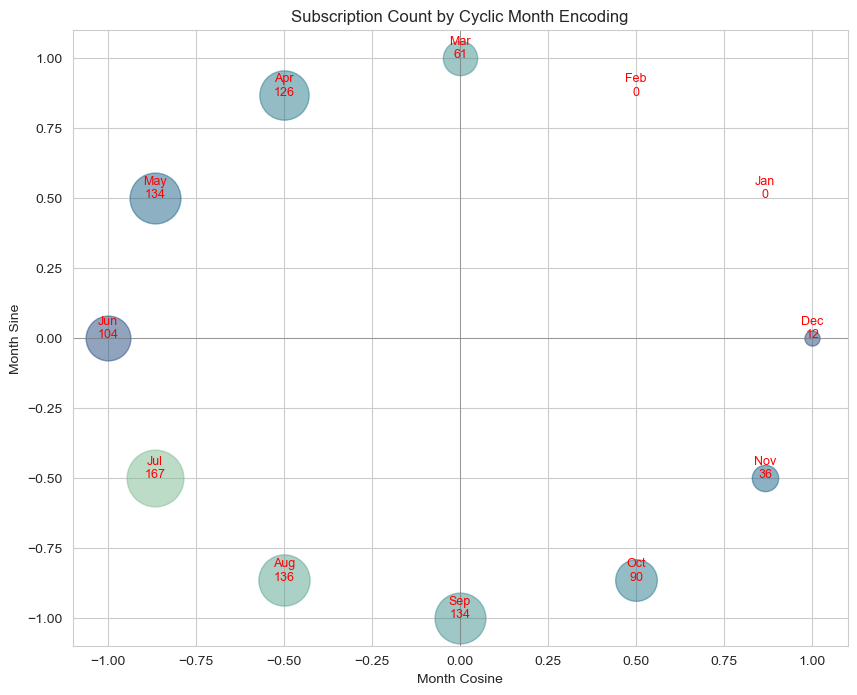

In [45]:
subscription_counts = df.groupby('month')['subscribed'].sum()

# Mapping of month numbers to abbreviations
month_to_abbr = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

plt.figure(figsize=(10, 8))
for month, count in subscription_counts.items():
    x = np.cos(2 * np.pi * month / 12)
    y = np.sin(2 * np.pi * month / 12)
    plt.scatter(x, y, s=count * 10, alpha=0.5)  # Scale point size by count
    annotation = f"{month_to_abbr[month]}\n{count}"
    plt.text(x, y, annotation, color='red', fontsize=9, ha='center')

plt.xlabel('Month Cosine')
plt.ylabel('Month Sine')
plt.title('Subscription Count by Cyclic Month Encoding')
plt.grid(True)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

plt.show()


Note how the radius of the circle relates to the number of subscriptions that month.

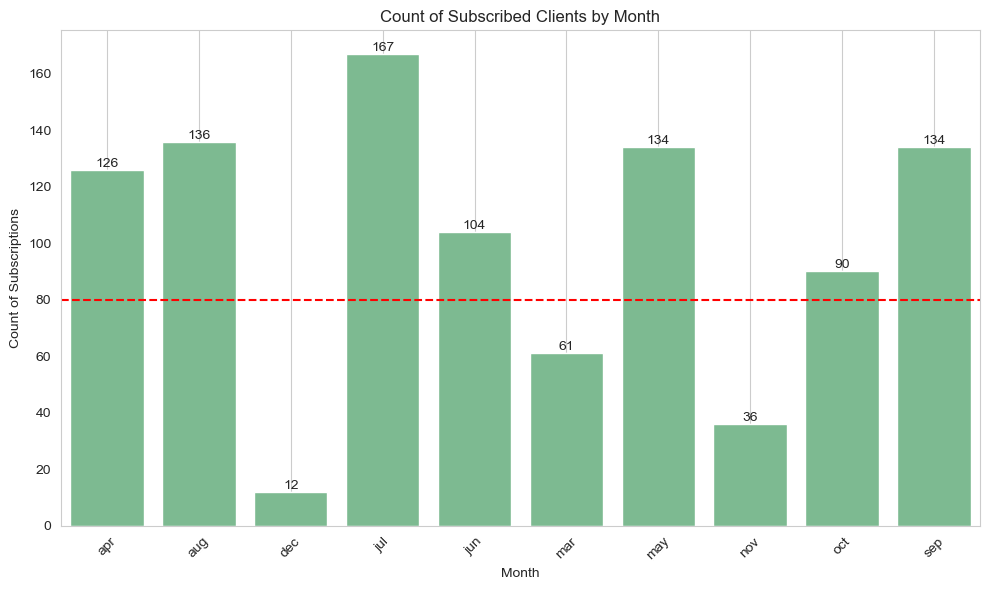

In [46]:
# Aggregate count of 'yes' subscriptions per month
subscription_counts = df_copy[df_copy['subscribed'] == 'yes'].groupby('month').size()

plt.figure(figsize=(10, 6))
subscription_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Count of Subscriptions')
plt.title('Count of Subscribed Clients by Month')
bars = plt.bar(subscription_counts.index, subscription_counts)

for bar in bars: # Annotate bars with actual count
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.axhline(y=80, color='red', linestyle='--')

plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Now, drop the original 'day' and 'month' columns

In [47]:
df.drop(columns=['day', 'month'], inplace=True)
df.head(5)

age  default  balance  housing  loan  campaign  pdays  previous  \
0  32.0        0      392        1     0         2    131         2   
1  39.0        0      688        1     1         2    133         1   
2  59.0        0     1035        1     1         2    239         1   
3  47.0        0      398        1     1         1    238         2   
4  54.0        0     1004        1     0         1    307         1   

   subscribed  job_admin.  ...  contact_cellular  contact_telephone  \
0           0         0.0  ...               1.0                0.0   
1           0         0.0  ...               1.0                0.0   
2           0         0.0  ...               1.0                0.0   
3           0         0.0  ...               1.0                0.0   
4           0         0.0  ...               1.0                0.0   

   contact_unknown  poutcome_failure  poutcome_other  poutcome_success  \
0              0.0               1.0             0.0               0.0   
1              0.0               1.0             0.0               0.0   
2              0.0               1.0             0.0               0.0   
3              0.0               1.0             0.0               0.0   
4              0.0               1.0             0.0               0.0   

    day_sin  day_cos  month_sin  month_cos  
0  0.201299  0.97953   0.866025       -0.5  
1  0.201299  0.97953   0.866025       -0.5  
2  0.201299  0.97953   0.866025       -0.5  
3  0.201299  0.97953   0.866025       -0.5  
4  0.201299  0.97953   0.866025       -0.5  

[5 rows x 38 columns]

## Handling  Outliers
### Utility Functions

In [48]:
def find_outliers(series, scale=1.5, quantiles=(0.25, 0.75)):
    
    Q1, Q3 = series.quantile(quantiles)

    IQR = Q3 - Q1
    lower_bound = Q1 - scale * IQR
    upper_bound = Q3 + scale * IQR

    return (lower_bound, upper_bound)

def describe_outliers(df,scale=1.5, quantiles=(0.25, 0.75)):
    """
    Calculates and describes the number of outliers for each numeric column in a DataFrame.

    Args:
    - df: pandas DataFrame, the DataFrame to analyse for outliers.
    - scale: float, the scale factor to apply for calculating bounds. 
    - quantiles: tuple, the quantiles to use for calculating IQR if method is 'iqr'.

    Method from here: https://youtu.be/VnoCze3pSqA?t=760

    Returns:
    - A summary dictionary with column names as keys and the number of outliers as values.
    """
    outlier_summary = {}

    if scale <= 0:
        raise ValueError("Scale should be greater than zero, typically 1.5.");

    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        series = df[column]

        (lower_bound, upper_bound) = find_outliers(series, scale, quantiles)

        # Identify and count outliers
        outliers = series[(series < lower_bound) | (series > upper_bound)]
        outlier_summary[column] = len(outliers)

    return outlier_summary

Let's identify which outliers we have. I will use the method described [here](https://youtu.be/VnoCze3pSqA?t=760).

In [49]:
describe_outliers(df_copy)

{'age': 24,
 'balance': 158,
 'day': 0,
 'duration': 92,
 'campaign': 212,
 'pdays': 33,
 'previous': 169}

We can see that we have outliers in: Age, Balance, Duration, Campiagn, pdays and previous. 

### What options do we have when dealing with outliers?
The short answer is that *it depends* on the data set and the context. If you modify the outliers you are likely changing the distribution; and this could be a bad thing. 

We can:

- **Do nothing** The values are valid observations. This is a good place to start experimenting. 
- **Remove outliers** We could do this if we think they are spurious/noisy data. 
- **Restrict values** using a ceiling or floor. I would use this if I wanted to dampen the effect of the outlier but not remove it.
- **Transformations** if the outliers skew the data, we could transform to a more normal distribution (e.g. log, sqrt, box-cox).

Fundamentally, dealing with outliers requires understanding the data and how it was collected. It is an iterative process that may require lots of experimentation (that is, create a pre-processing pipeline, test on a set of ML algorithms and evaluate the test accuracy, iterate). I want to start by understanding the full spectrum of values in the data set before I start to change the data.

Let's start with age.

### Age
Recall, age had the following distribution:

In [50]:
df_copy['age'].describe()

count    1988.000000
mean       41.753018
std        12.724358
min        18.000000
25%        32.000000
50%        38.000000
75%        50.000000
max        93.000000
Name: age, dtype: float64

I will not transform age for the previously stated reasons: I believe the distriburtion is important. 

### Balance
Recall, balance had the following distribution:

In [51]:
df_copy['balance'].describe()

count     2000.000000
mean      1413.663500
std       3131.224213
min       -980.000000
25%        201.500000
50%        551.000000
75%       1644.500000
max      81204.000000
Name: balance, dtype: float64

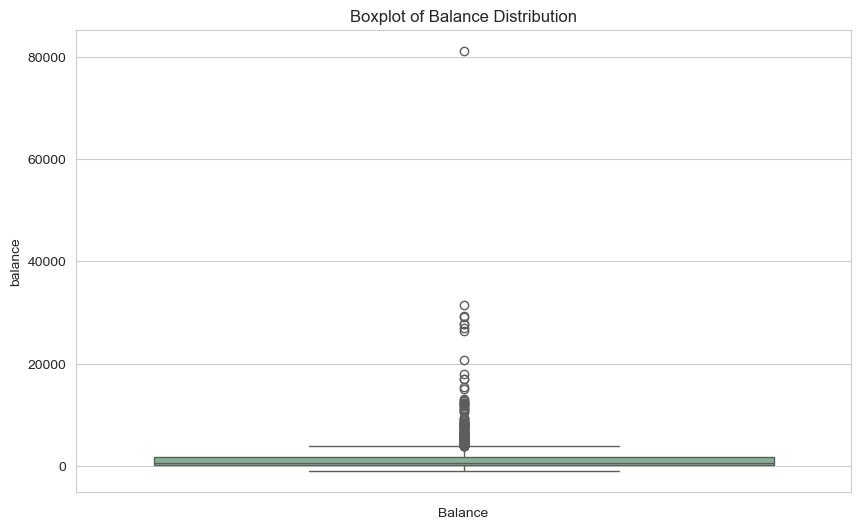

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(df_copy['balance'])
plt.title('Boxplot of Balance Distribution')
plt.xlabel('Balance')
plt.show()

I will not transform balance as I want to start by understanding the full spectrum of values in the data set.  I will leave as-is for now.

### Duration, Campaign, pdays & previous
Duration is dropped and, for the remainder, I see no reason to transform these values at this point. Each of these values report valuable information about the marketing campaign. It may be that, once I put this through an ML algorithm, I might wish to transform this data further.

## Scaling

We wil need to assess the type of scaling that may be required. And this is where the *data wrangling* comes in. You need to build experiments, with different setups, and measure the effect on the output. This can be quite laborious. 

Here I will focus on age and balance. But I will generally use a [standard scaler](https://scikit-learn.org/1.4/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) to start with. The standardscaler will preserve the shape of the distribution. Once I scale these features, it's more difficult to tie them to the real-world.

It is worth noting that the RobustScaler could be a better choice than StandardScaler because it's less influenced by outliers. Also, we could also use the [Quantile Transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html#sklearn.preprocessing.quantile_transform) to reduce the impact of outliers but I have not done enough work to see if it distorts relationships in this data set (this requires more time).

In this case, I know, from testing with the SVM (shown in the appendix), that the standard scaler yields the best performance. The key takeaway is that, for the linear kernel, using the standard scaler on the numeric features allows me to imporve the accuracy from 0.935 to 0.945. Furthermore, moving to the non-linear kernel further improves the accuracy to 0.975. the standardscaler also improves the training time considerably.

In [53]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['age', 'balance', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


df.head(5)

age  default   balance  housing  loan  campaign     pdays  previous  \
0 -0.767012        0 -0.326364        1     0  0.065650 -0.280107 -0.165153   
1 -0.215233        0 -0.231809        1     1  0.065650 -0.264923 -0.459280   
2  1.361277        0 -0.120962        1     1  0.065650  0.539807 -0.459280   
3  0.415371        0 -0.324447        1     1 -0.659767  0.532215 -0.165153   
4  0.967150        0 -0.130864        1     0 -0.659767  1.056049 -0.459280   

   subscribed  job_admin.  ...  contact_cellular  contact_telephone  \
0           0         0.0  ...               1.0                0.0   
1           0         0.0  ...               1.0                0.0   
2           0         0.0  ...               1.0                0.0   
3           0         0.0  ...               1.0                0.0   
4           0         0.0  ...               1.0                0.0   

   contact_unknown  poutcome_failure  poutcome_other  poutcome_success  \
0              0.0               1.0             0.0               0.0   
1              0.0               1.0             0.0               0.0   
2              0.0               1.0             0.0               0.0   
3              0.0               1.0             0.0               0.0   
4              0.0               1.0             0.0               0.0   

    day_sin  day_cos  month_sin  month_cos  
0  0.201299  0.97953   0.866025       -0.5  
1  0.201299  0.97953   0.866025       -0.5  
2  0.201299  0.97953   0.866025       -0.5  
3  0.201299  0.97953   0.866025       -0.5  
4  0.201299  0.97953   0.866025       -0.5  

[5 rows x 38 columns]

## Creating new features from existing features
Side-note: Technically, I have done this by splitting the day and month into a cyclical feature with two components.



## Review & Save Preprocessed Dataframe

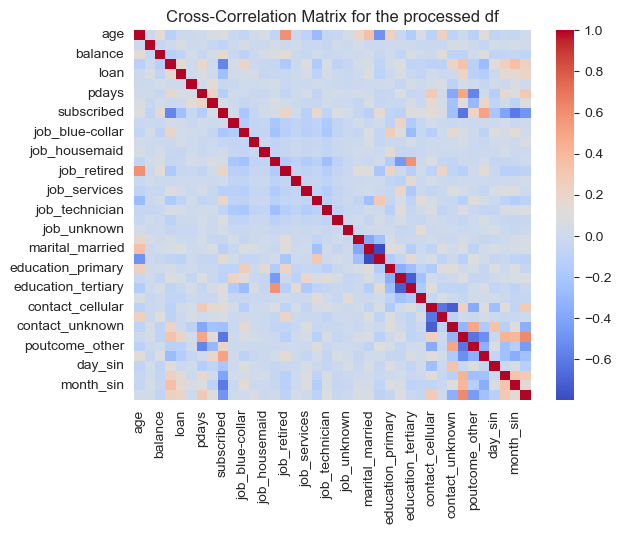

In [54]:
# Calculating the correlation matrix
corr_matrix = df.corr()

sns.heatmap(corr_matrix,  fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Cross-Correlation Matrix for the processed df')
plt.show()

subscribed             1.000000
poutcome_success       0.510117
poutcome_other         0.214842
job_retired            0.201587
job_student            0.182442
balance                0.150395
marital_single         0.143859
contact_cellular       0.142930
education_tertiary     0.113833
age                    0.086590
education_unknown      0.076567
job_unemployed         0.073969
contact_telephone      0.069194
previous               0.058678
job_management         0.048676
job_unknown            0.028355
job_admin.             0.019756
job_housemaid          0.019066
job_self-employed      0.017045
campaign              -0.034457
marital_divorced      -0.043584
job_entrepreneur      -0.050572
default               -0.075339
education_primary     -0.078775
job_technician        -0.079133
education_secondary   -0.093001
marital_married       -0.109678
job_services          -0.118128
pdays                 -0.132887
day_sin               -0.196431
job_blue-collar       -0.202197
contact_

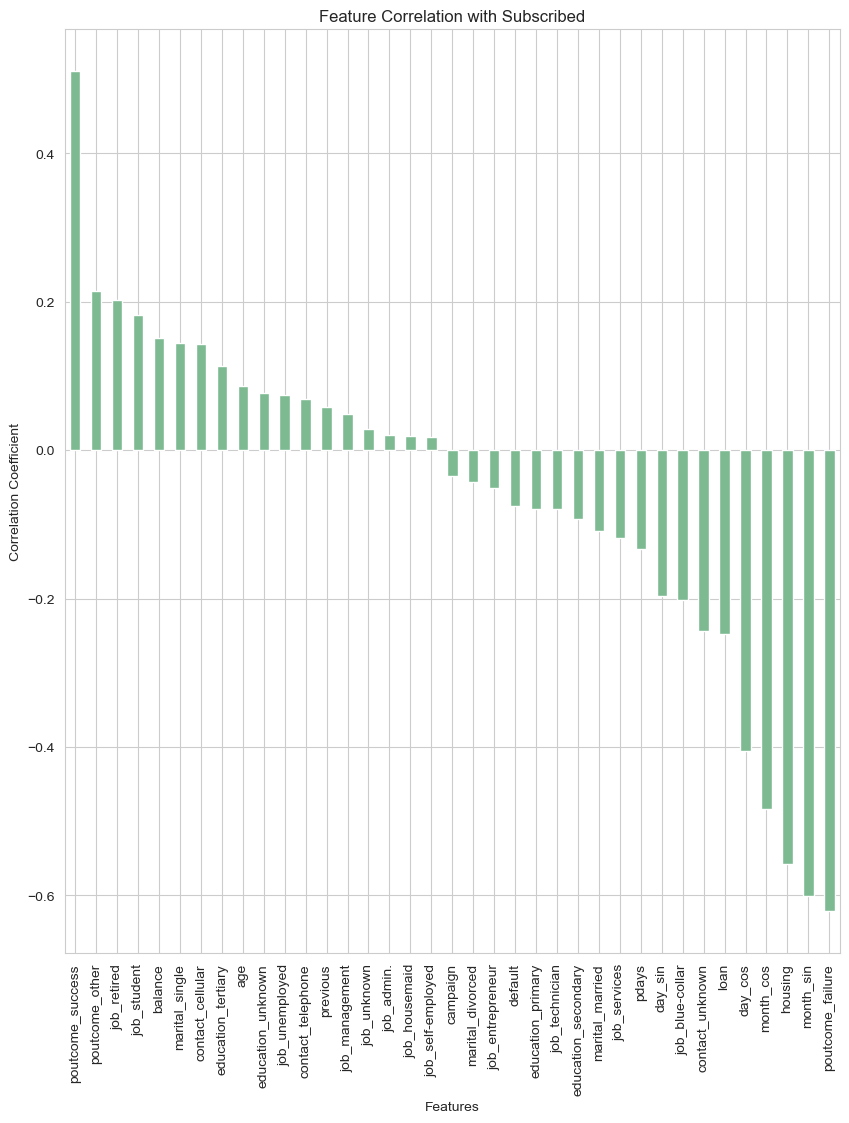

In [55]:
# Extract correlations with the 'subscribed' column
subscribed_corr = corr_matrix['subscribed'].sort_values(ascending=False)

print(subscribed_corr)

plt.figure(figsize=(10, 12))

subscribed_corr.drop('subscribed').plot(kind='bar')  # Dropping the 'subscribed' vs 'subscribed' correlation
plt.title('Feature Correlation with Subscribed')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

In [56]:
output_path_final = 'bank_preprocessed_manual.csv' # later I will compare the manual and pipeline csv files and confirm they are identical

df.to_csv(output_path_final, index=False)
print(f"Preprocessed data saved to: {output_path_final}")

Preprocessed data saved to: bank_preprocessed_manual.csv


The previous section shows how and why we might manually transform data to account for skew - the plots on the right show some improvement in skew. The SVM example in appendix A1, A2 shows a better way to do this preprocessing (less erroneprone).

## Putting it all together: Saving the prepared dataset
The following section combines all of the previous manual steps into a data preparation pipeline to perform:

- Numerical Imputation
- Numerical Standard Scaling
- Categorical Imputation
- Targeted Categorical Binary & OneHot Encoding
- Cyclical features for day and month

The processed data set is saved to CSV, reading for SVM (or whatever we choose to use). 

### Encoding day and month as cyclical features

To create cyclical features, I will transform both the day and month columns. Since the maximum value for days can vary from month to month, I will use a general approach that assumes a generic month length of 31 days for simplicity. For the month column, we'll convert the three-letter abbreviations to numerical values ranging from 1 (January) to 12 (December), then apply the cyclical transformation to both columns as part of the sci-kit pipeline.

I will need to create a custom transformer that I can use in the pipeline. I will do this first.Then I will pre-process the dataframe and save to a csv file, reading for use with an ML algorithm (or set of).

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class CyclicalFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to convert day and month to cyclical features 

    This is inserted into the scikit pipeline and executed at 'fit' time.
    """
    def __init__(self):
        """Not required"""
        pass
    
    def month_to_num(self, month):
        """Map string month to array index + 1"""
        months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        return months.index(month.lower()) + 1

    def create_cyclical_features(self, X, col, max_val):
        """
        Generate the cyclical feature - max_val will change depending on whether it is day or month
        We're essentially mapping the int to a circle.
        """
        X[col + '_sin'] = np.sin(2 * np.pi * X[col]/max_val)
        X[col + '_cos'] = np.cos(2 * np.pi * X[col]/max_val)
        return X
    
    def fit(self, X, y=None):
        """Allows us to use in the scikit pipeline"""
        return self
    
    def transform(self, X, y=None):
        """
        Do the actual transformation
        """
        
        # Ensure we're working with a copy to avoid changing the original dataframe
        X = X.copy()
        
        # Convert month to numerical value
        X['month_num'] = X['month'].apply(self.month_to_num)
        
        # Create cyclical features for day (max 31 days) and month (max 12 months)
        X = self.create_cyclical_features(X, 'day', 31)
        X = self.create_cyclical_features(X, 'month_num', 12)
        
        # Drop original day and month columns to avoid duplicating information
        X.drop(['day', 'month', 'month_num'], axis=1, inplace=True)
        
        return X

Now we create and run the pre-processing pipeline. The output it a csv file called `bank_processed_pipeline.csv`.

In [58]:
# Load the dataset
df = pd.read_csv('bank.csv')
df.drop('duration', axis=1, inplace=True)

df.loc[df['pdays'] == -1, 'poutcome'] = 'other' #we know from EDA that this is likely true

# Identify numerical and categorical columns - so I can treat them differently
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Pipeline for numerical attributes - I could add more robust skew-handling here but I wont - 
# see appendix A1 for an example of how to do this using a threshold.
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # fill empty numbers with mean value
    #('power_transform', PowerTransformer(method='yeo-johnson')), # Skew Handling - chosen to allow +/- numbers
    ('scaler', StandardScaler()) #potentially sensitive to outliers but worked very well on SVM (see appendix)
])

# Pipeline for categorical attributes (excluding binary yes/no columns)
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), #fill empty categories with unknown
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # onehot encode
])

def binary_encode(df):
    """
    Binary encoding function for yes/no columns - convert to 1/0
    """
    return df.applymap(lambda x: 1 if x == 'yes' else (0 if x == 'no' else x))

# Pipeline for binary attributes (yes/no)
binary_pipeline = Pipeline([
    ('binary_encoder', FunctionTransformer(binary_encode))
])

# Build transformation pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_cols),
        ('one-hot-cat', categorical_pipeline, categorical_cols[categorical_cols.isin(['default', 'housing', 'loan', 'subscribed']) == False]),
        ('binary', binary_pipeline, ['default', 'housing', 'loan', 'subscribed']),
        ('cyclical', CyclicalFeatureTransformer(), ['day', 'month'])  # Add this line
    ])

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# The next section is concerned with making sure we retain the column names in the output csv
# Extract feature names for one-hot encoded columns
onehot_features_with_prefix = preprocessor.named_transformers_['one-hot-cat'].named_steps['onehot'].get_feature_names_out()
original_categorical_cols = categorical_cols[categorical_cols.isin(['default', 'housing', 'loan', 'subscribed']) == False]
updated_onehot_features = [f"{col}_{feature.split('_')[-1]}" for col in original_categorical_cols for feature in onehot_features_with_prefix if feature.startswith(f"x{list(original_categorical_cols).index(col)}_")]

# Manually add the cyclical feature names
cyclical_feature_names = ['day_sin', 'day_cos', 'month_sin', 'month_cos']

# Combine all feature names including numerical, one-hot encoded with prefixes, and binary encoded features
all_features = list(numerical_cols) + updated_onehot_features + ['default', 'housing', 'loan', 'subscribed'] + cyclical_feature_names

# Create the final preprocessed DataFrame
df_preprocessed = pd.DataFrame(df_transformed, columns=all_features)

# Cleanup Dataframe
# 1. Drop the specified columns from the DataFrame
# List of columns to be removed
columns_to_remove = [
    'day', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 
    'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 
    'month_oct', 'month_sep'
]

df_preprocessed = df_preprocessed.drop(columns=columns_to_remove, axis=1)

# 2. Create a list of all column names except 'subscribed'
columns_except_subscribed = [col for col in df_preprocessed.columns if col != 'subscribed']

# 3. Add 'subscribed' to the end of the list
columns_reordered = columns_except_subscribed + ['subscribed']

# 4. Reorder the DataFrame using the new column order
df_preprocessed = df_preprocessed[columns_reordered]

# Save the DataFrame to CSV for downstream use.
output_path_final = 'bank_preprocessed_pipeline.csv'
df_preprocessed.to_csv(output_path_final, index=False)
print(f"Preprocessed data saved to: {output_path_final}")

Preprocessed data saved to: bank_preprocessed_pipeline.csv


I do the following just so I can visualise the pipeline. Note, Im not actually using the SVM here; this is to visualise the pipeline I have created. 

In [59]:
from sklearn.svm import SVC
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='linear', random_state=5))
])

svm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('one-hot-cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder...e'))]),
                                                  Index(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], dtype='object')),
                                                 ('binary',
                                                  Pipeline(steps=[('binary_encoder',
                                                                   FunctionTransformer(func=<function binary_encode at 0x34b7714e0>))]),
                                                  ['default', 'housing', 'loan',
                                                   'subscribed']),
                                                 ('cyclical',
                                                  CyclicalFeatureTransformer(),
                                                  ['day', 'month'])])),
                ('model', SVC(kernel='linear', random_state=5))])

Confirm the data was transformed as expected. We have the headings int he right place but the skew corrected and scaled data is difficult to interpret.

In [60]:
df_preprocessed.head(5)

age   balance  campaign     pdays  previous  job_admin.  \
0 -0.768987 -0.326364  0.065650 -0.280107 -0.165153         0.0   
1 -0.217065 -0.231809  0.065650 -0.264923 -0.459280         0.0   
2  1.359857 -0.120962  0.065650  0.539807 -0.459280         0.0   
3  0.413704 -0.324447 -0.659767  0.532215 -0.165153         0.0   
4  0.965627 -0.130864 -0.659767  1.056049 -0.459280         0.0   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  ...  \
0              0.0               0.0            0.0             0.0  ...   
1              0.0               0.0            0.0             0.0  ...   
2              0.0               0.0            0.0             0.0  ...   
3              1.0               0.0            0.0             0.0  ...   
4              0.0               0.0            0.0             0.0  ...   

   poutcome_other  poutcome_success  default  housing  loan   day_sin  \
0             0.0               0.0      0.0      1.0   0.0  0.201299   
1             0.0               0.0      0.0      1.0   1.0  0.201299   
2             0.0               0.0      0.0      1.0   1.0  0.201299   
3             0.0               0.0      0.0      1.0   1.0  0.201299   
4             0.0               0.0      0.0      1.0   0.0  0.201299   

   day_cos  month_sin  month_cos  subscribed  
0  0.97953   0.866025       -0.5         0.0  
1  0.97953   0.866025       -0.5         0.0  
2  0.97953   0.866025       -0.5         0.0  
3  0.97953   0.866025       -0.5         0.0  
4  0.97953   0.866025       -0.5         0.0  

[5 rows x 38 columns]

In [61]:
df_preprocessed.tail(5)

age   balance  campaign     pdays  previous  job_admin.  \
1995 -1.715141  0.438065  0.065650 -1.282224 -0.753408         0.0   
1996 -1.084372 -0.411017  0.065650 -1.282224 -0.753408         1.0   
1997  3.094471 -0.082948 -0.659767 -1.282224 -0.753408         0.0   
1998  0.334858  0.935758 -0.659767 -1.282224 -0.753408         0.0   
1999 -0.138219  1.593813  0.065650 -1.282224 -0.753408         0.0   

      job_blue-collar  job_entrepreneur  job_housemaid  job_management  ...  \
1995              0.0               0.0            0.0             0.0  ...   
1996              0.0               0.0            0.0             0.0  ...   
1997              0.0               0.0            0.0             0.0  ...   
1998              0.0               0.0            0.0             0.0  ...   
1999              0.0               1.0            0.0             0.0  ...   

      poutcome_other  poutcome_success  default  housing  loan   day_sin  \
1995             1.0               0.0      0.0      0.0   0.0 -0.101168   
1996             1.0               0.0      0.0      0.0   0.0 -0.101168   
1997             1.0               0.0      0.0      0.0   0.0 -0.299363   
1998             1.0               0.0      0.0      1.0   0.0 -0.790776   
1999             1.0               0.0      0.0      0.0   0.0 -0.968077   

       day_cos  month_sin     month_cos  subscribed  
1995 -0.994869       -1.0 -1.836970e-16         1.0  
1996 -0.994869       -1.0 -1.836970e-16         1.0  
1997 -0.954139       -1.0 -1.836970e-16         1.0  
1998 -0.612106       -1.0 -1.836970e-16         1.0  
1999 -0.250653       -1.0 -1.836970e-16         1.0  

[5 rows x 38 columns]

# References

- [How to use Square Root, log, & Box-Cox Transformation in Python](https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/)
- [Log Transformation: Purpose and Interpretation](https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9)
- [Chapter 5: Feature Engineering](https://www.amazon.com/Designing-Machine-Learning-Systems-Production-Ready/dp/1098107969)
- [Vioin Plots Explained](https://towardsdatascience.com/violin-plots-explained-fb1d115e023d)
- [A complete guide to violin plots](https://www.atlassian.com/data/charts/violin-plot-complete-guide)
- [Encoding Cyclical Features](https://medium.com/@axelazara6/why-we-need-encoding-cyclical-features-79ecc3531232)
- [A Data-Driven Approach to Predict the
Success of Bank Telemarketing](https://repositorio.iscte-iul.pt/bitstream/10071/9499/5/dss_v3.pdf)

# Appendix

## A1. Using an SVM to Predict Subscription (Linear Kernel)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer

This section shows how an SVM might be used to predict whether or not a person is likely to subscribe. 

The approach will be to:

1. Identifying categorical and numerical columns.
2. Creating transformers for numerical and categorical columns.
3. Combining transformers into a ColumnTransformer.
4. Prep the data set for training and evaluation.
5. Build a pipeline that includes preprocessing (imputation, one-hot encoding for numerical and categorical variables).
6. Training the SVM
7. Evaluation
8. Plot

I use [imputation strategies](https://scikit-learn.org/stable/modules/impute.html) to transform the data set as part of a preprocessing pipeline. This allows for a cleaner solution, compared to performing manual (and error-prone) imputation.

### Not using a standard scaler on Numerical Values

Preprocessing consists of:

**Numerical**
- Simple Imputation with mean

**Categorical**
- Simple Imputation with 'unknown'
- Onehot encoding for all

In [63]:
df = pd.read_csv('bank.csv')
df.drop('duration', axis=1, inplace=True)

df.loc[df['pdays'] == -1, 'poutcome'] = 'other'

categorical_cols = df.select_dtypes(include=['object']).drop(columns=['subscribed']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), # Imputing missing values for categorical data
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encoding categorical features
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X = df.drop('subscribed', axis=1)
y = df['subscribed'].map({'yes': 1, 'no': 0}) # Encoding the target variable as binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='linear', random_state=5))
])

svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.92

In [64]:
svm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('model', SVC(kernel='linear', random_state=5))])

**Note:** Without standard scaler this takes approx. 3m 5s on an M1 Ultra.

### Using a standard Scaler on Numerical Values

Preprocessing consists of:

**Numerical**
- Simple Imputation with mean
- Standard Scaling

**Categorical**
- Simple Imputation with 'unknown'
- Onehot encoding for all

In [65]:
df = pd.read_csv('bank.csv')
df.drop('duration', axis=1, inplace=True)

df.loc[df['pdays'] == -1, 'poutcome'] = 'other'

categorical_cols = df.select_dtypes(include=['object']).drop(columns=['subscribed']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Imputing missing values
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), # Imputing missing values for categorical data
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encoding categorical features
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X = df.drop('subscribed', axis=1)
y = df['subscribed'].map({'yes': 1, 'no': 0}) # Encoding the target variable as binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='linear', random_state=5))
])

svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.94

**Note** that training is much faster with standard scaling (almost instantaeous on an M1 Ultra).

In [66]:
svm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('model', SVC(kernel='linear', random_state=5))])

Plot the ROC for the classifier. This requires that I predict [decision function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function) scores instead of probabilities for ROC curve (SVM specific)

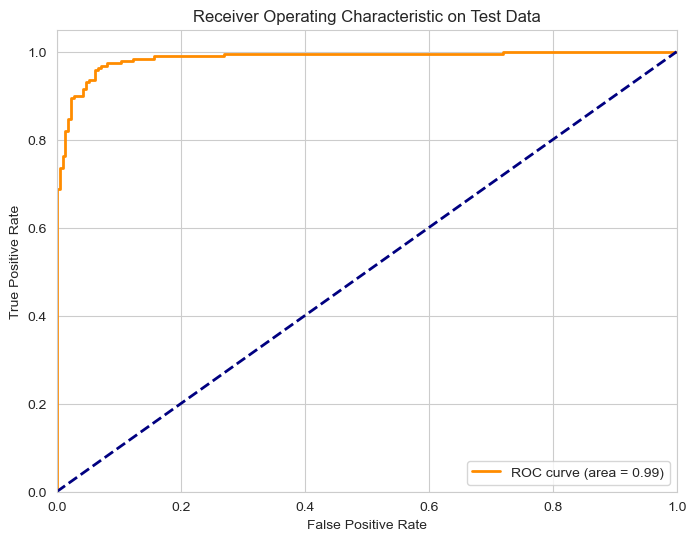

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, auc
import matplotlib.pyplot as plt

y_scores = svm_pipeline.decision_function(X_test) #(SVM specific)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic on Test Data')
plt.legend(loc="lower right")
plt.show()

Generating Classification Report

In [68]:
y_pred = svm_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       211
           1       0.93      0.94      0.94       189

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



The key takeaway is that, for the linear kernel, using the standard scaler on the numeric features allows me to imporve the accuracy from 0.935 to 0.945.

### Identify the underlying important features

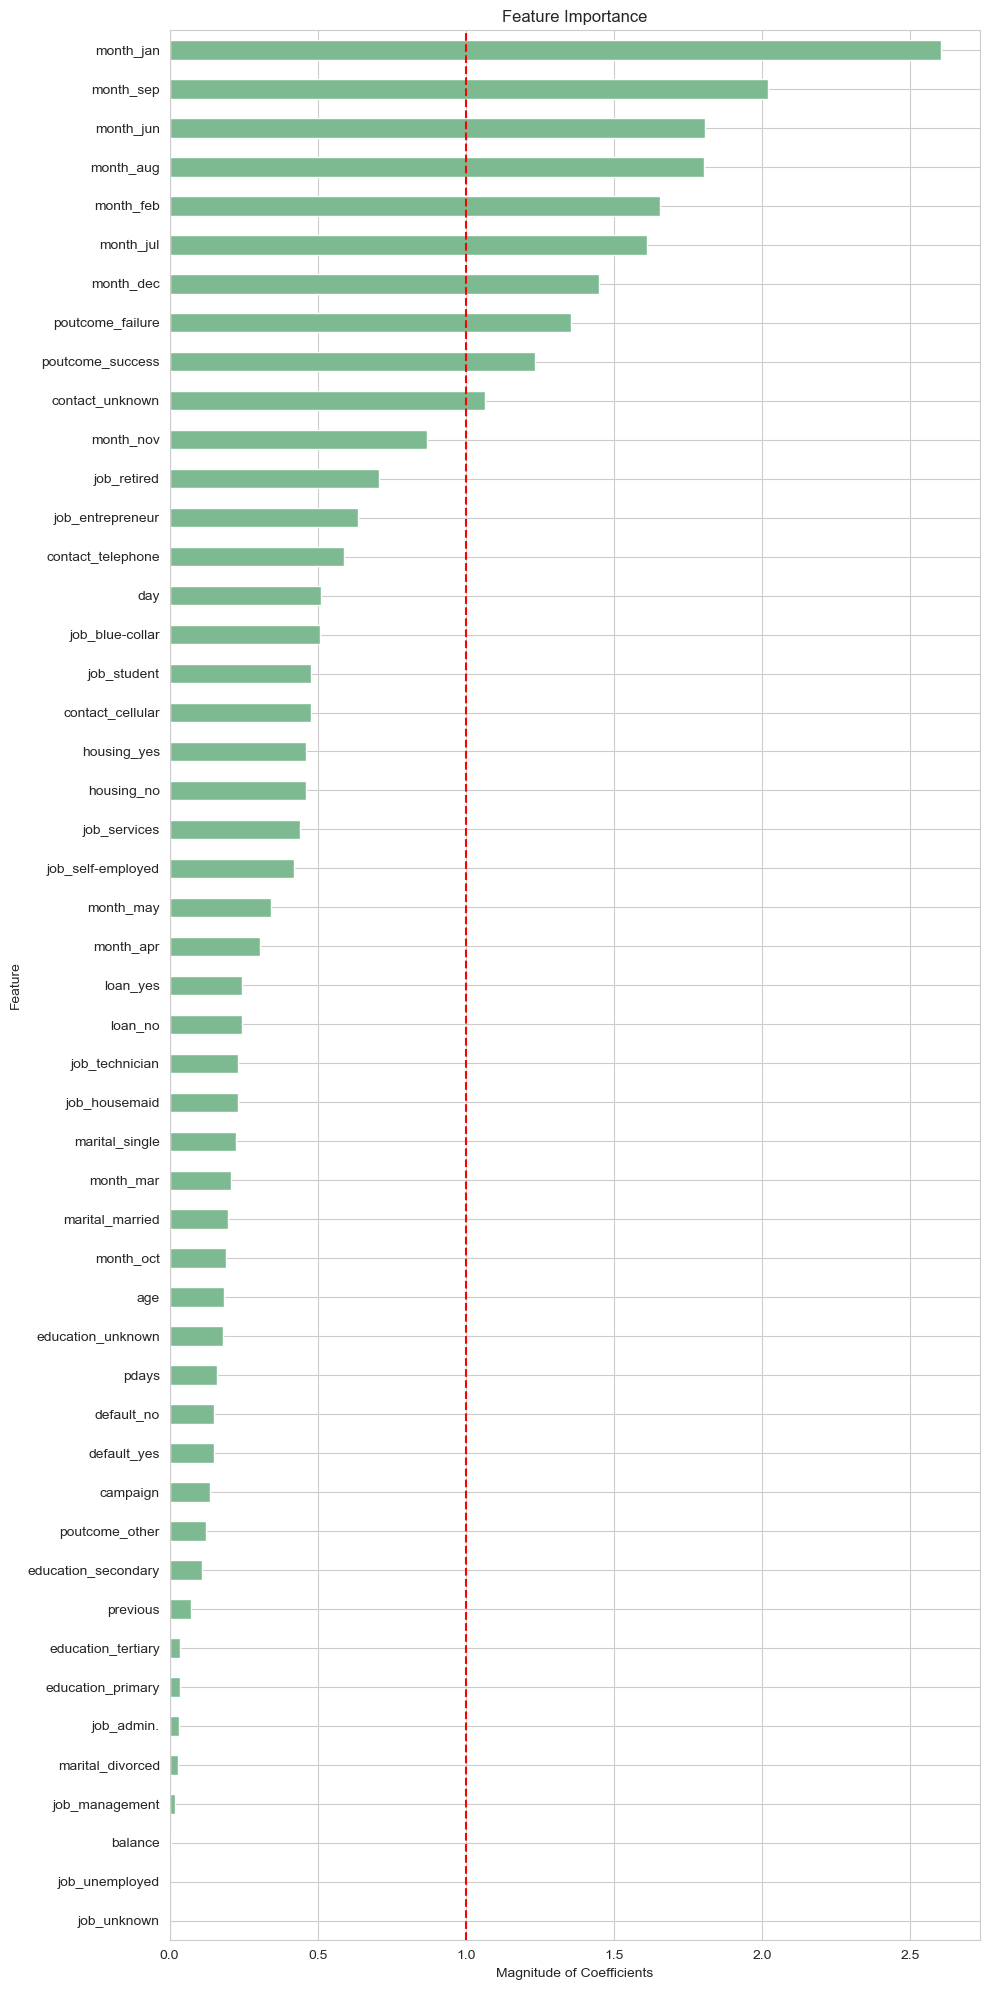

In [69]:
feature_names_transformed = svm_pipeline.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

feature_names = np.concatenate([numerical_cols, feature_names_transformed])

svm_coef = svm_pipeline.named_steps['model'].coef_[0]

feature_importance = pd.Series(svm_coef, index=feature_names)

feature_importance_sorted = feature_importance.abs().sort_values(ascending=True)

plt.figure(figsize=(10, 20))
feature_importance_sorted.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Magnitude of Coefficients')
plt.axvline(x=1, color='r', linestyle='--') # This line may need adjustment based on actual coefficient values
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Try an SVM with non-linear kernel

Preprocessing consists of:

**Numerical**
- Simple Imputation with mean
- Standard Scaling

**Categorical**
- Simple Imputation with 'unknown'
- Onehot encoding for all

In [70]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline with an RBF kernel
svm_pipeline_rbf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='rbf', random_state=5))
])

# Parameter grid for GridSearchCV
param_grid = {
    'model__C': [0.1, 1, 10, 100],  # Regularisation parameter
    'model__gamma': ['scale', 'auto', 0.1, 1, 10, 100]  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Setup the GridSearchCV
grid_search = GridSearchCV(svm_pipeline_rbf, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best model after grid search
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9625

In [71]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('model', SVC(C=10, gamma='auto', random_state=5))])

In [72]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       211
           1       0.96      0.96      0.96       189

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



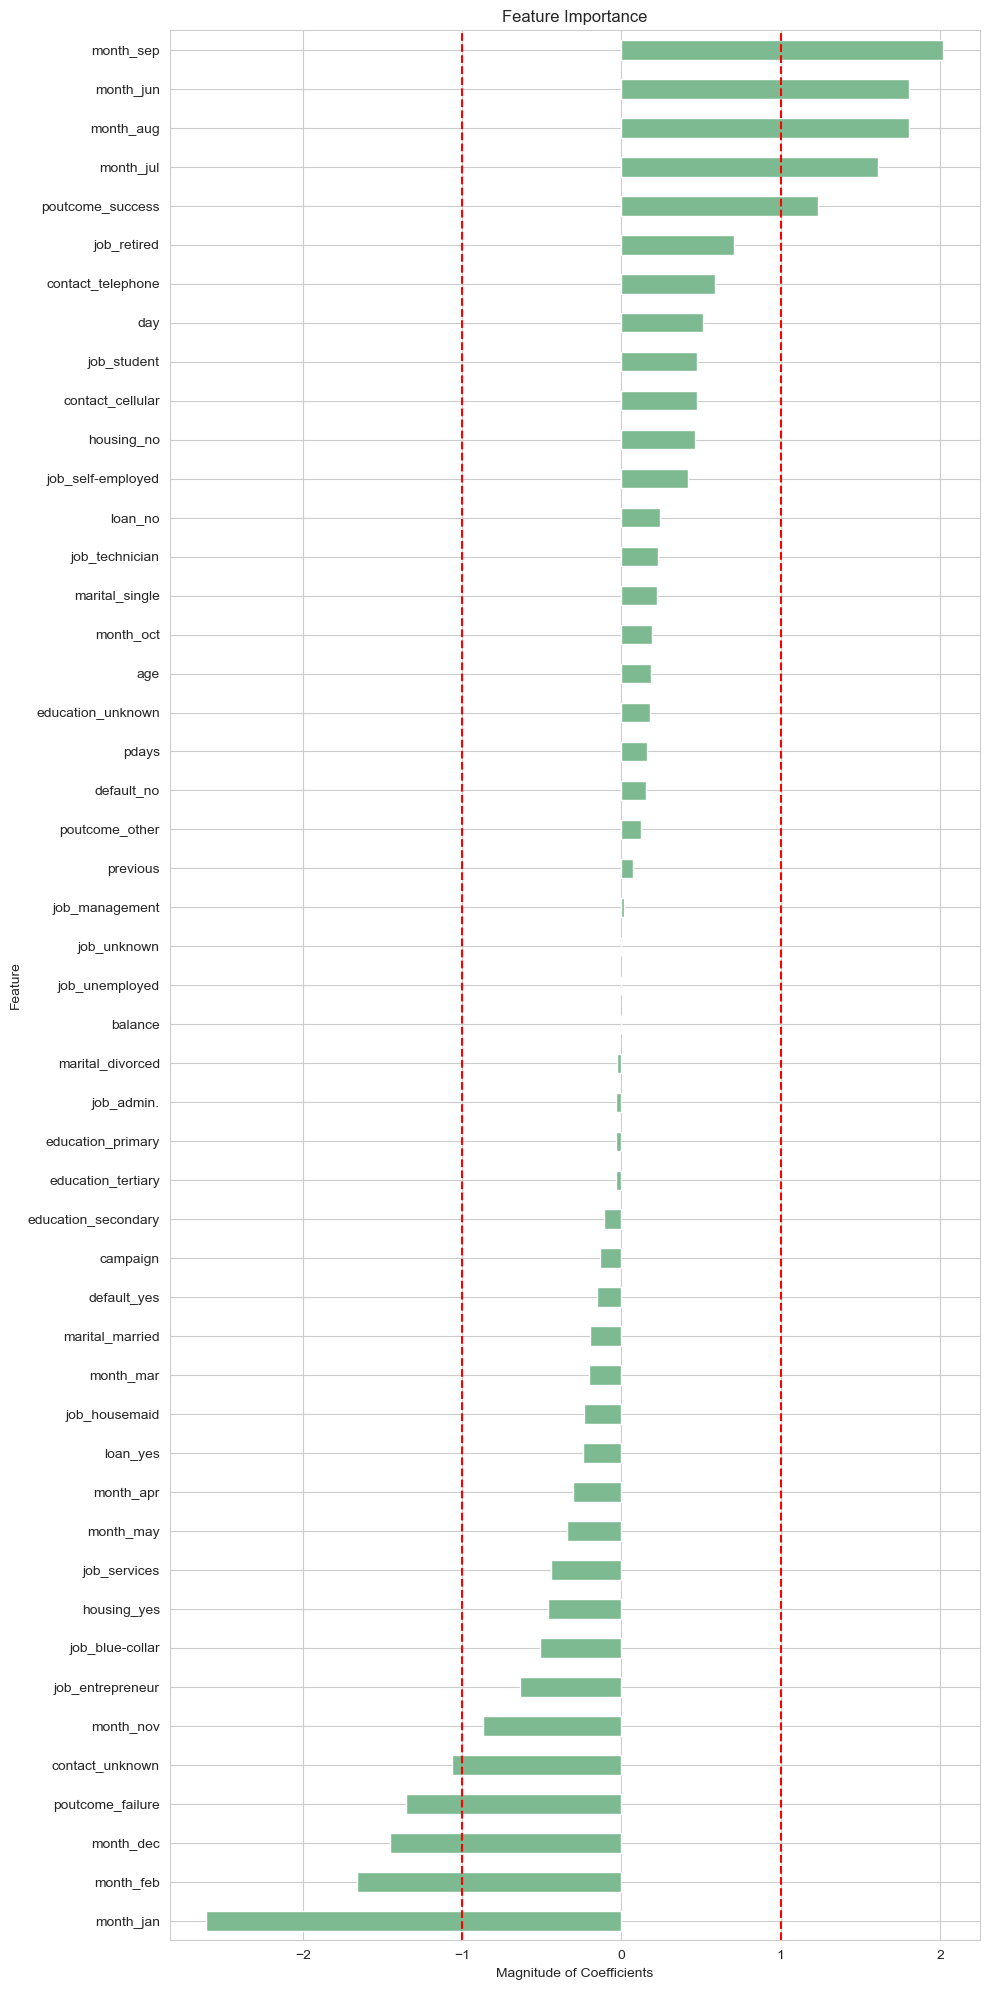

In [73]:
feature_names_transformed = best_model.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

feature_names = np.concatenate([numerical_cols, feature_names_transformed])

svm_coef = svm_pipeline.named_steps['model'].coef_[0]

feature_importance = pd.Series(svm_coef, index=feature_names)
feature_importance_sorted = feature_importance.sort_values(ascending=True)

# Plotting
plt.figure(figsize=(10, 20))
feature_importance_sorted.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Magnitude of Coefficients')
plt.axvline(x=1, color='r', linestyle='--') # This line may need adjustment based on actual coefficient values
plt.axvline(x=-1, color='r', linestyle='--')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## A2. Using a Non-linear SVM
This example shows the use of a nonlinear SVM to classify whether or not a respondent will subscribe to a term loan. I show the use of pipelines to perform scaling, imputation and various kinds of encoding.

This first example determines the amount of skewness and, based on an arbitrary threshold, applies a PowerTransform on the more highly skewed data.

In [74]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew

df = pd.read_csv('bank.csv')
df.drop('duration', axis=1, inplace=True)
df.loc[df['pdays'] == -1, 'poutcome'] = 'other'

categorical_cols = df.select_dtypes(include=['object']).drop(columns=['subscribed']).columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Calculate skewness and separate features
skewness = df[numerical_cols].apply(lambda x: skew(x.dropna()))
highly_skewed_features = skewness[abs(skewness) > 0.75].index.tolist()
not_highly_skewed_features = skewness[abs(skewness) <= 0.75].index.tolist()

# Preprocessing for numerical features
numerical_transformer_highly_skewed = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

numerical_transformer_not_highly_skewed = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num_highly_skewed', numerical_transformer_highly_skewed, highly_skewed_features),
    ('num_not_highly_skewed', numerical_transformer_not_highly_skewed, not_highly_skewed_features),
    ('cat', categorical_transformer, categorical_cols)
])

# SVM pipeline
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', random_state=5))
])

# Setup and fit GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.1, 1, 10, 100]
}

X = df.drop('subscribed', axis=1)
y = df['subscribed'].map({'yes': 1, 'no': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy}")


Model accuracy: 0.9625


Here I show the pipeline, in graphical form.

In [75]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_highly_skewed',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transform',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('num_not_highly_skewed',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['day']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object'))])),
                ('classifier', SVC(C=10, gamma='auto', random_state=5))])

In [76]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       211
           1       0.96      0.96      0.96       189

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



The extra care, given for Skew, do not impact the outcome significantly.

## A3. Outlier Handling

In [77]:
df = pd.read_csv('bank.csv')

In [78]:
def calculate_iqr_bounds(series, scale=1.5):
    """
    Calculates the lower and upper bounds for outlier detection based on the IQR.

    From: https://youtu.be/VnoCze3pSqA?t=760 - "IQR is not perfect"

    Parameters:
    - series: pandas Series from which to calculate the IQR bounds.
    - scale: float, the scale factor to apply to the IQR for calculating bounds.

    Returns:
    - lower_bound: float, the calculated lower bound.
    - upper_bound: float, the calculated upper bound.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - scale * IQR
    upper_bound = Q3 + scale * IQR
    return lower_bound, upper_bound

In [79]:
markdown_table = "| Feature | Original Min | Original Max | New Min | New Max |\n"
markdown_table += "|---------|--------------|--------------|---------|---------|\n"

# Iterate over numerical columns to calculate original and new bounds
for col in df.select_dtypes(include=np.number).columns:
    # Store original min and max
    original_min, original_max = df[col].min(), df[col].max()
    
    # Calculate new bounds (this step depends on your specific implementation)
    # For demonstration, let's assume calculate_iqr_bounds returns bounds
    # and you clip the DataFrame's column to these bounds afterwards
    lower_bound, upper_bound = calculate_iqr_bounds(df[col], scale=1.5)
    
    # Apply clipping based on calculated IQR bounds to simulate the new min and max
    # This is for demonstration; replace with your actual data transformation step
    new_min, new_max = df[col].clip(lower=lower_bound, upper=upper_bound).agg(['min', 'max'])
    
    # Append the data to the markdown string
    markdown_table += f"| {col} | {original_min:.2f} | {original_max:.2f} | {new_min:.2f} | {new_max:.2f} |\n"

# Display the markdown table
Markdown(markdown_table)

| Feature | Original Min | Original Max | New Min | New Max |
|---------|--------------|--------------|---------|---------|
| age | 18.00 | 93.00 | 18.00 | 77.00 |
| balance | -980.00 | 81204.00 | -980.00 | 3809.00 |
| day | 1.00 | 31.00 | 1.00 | 31.00 |
| duration | 7.00 | 1823.00 | 7.00 | 728.50 |
| campaign | 1.00 | 11.00 | 1.00 | 3.50 |
| pdays | -1.00 | 854.00 | -1.00 | 513.88 |
| previous | 0.00 | 55.00 | 0.00 | 6.00 |


### Filtering outliers

In [80]:
def filter_outliers_iqr(dataframe, scale=1.5):
    """
    Filters outliers from the DataFrame based on the IQR method.

    From: https://youtu.be/VnoCze3pSqA?t=760

    Parameters:
    - dataframe: pandas DataFrame to filter.
    - scale: float, the scale factor to apply to the IQR for calculating bounds.

    Returns:
    - filtered_df: pandas DataFrame, the DataFrame with outliers removed.
    """
    filtered_df = dataframe.copy()
    for col in dataframe.select_dtypes(include=np.number).columns:
        lower_bound, upper_bound = calculate_iqr_bounds(dataframe[col], scale=scale)
        filtered_df = filtered_df[(filtered_df[col] > lower_bound) & (filtered_df[col] < upper_bound)]
    return filtered_df

#### Filtering outliers detected by IQR (Scale 1.5)

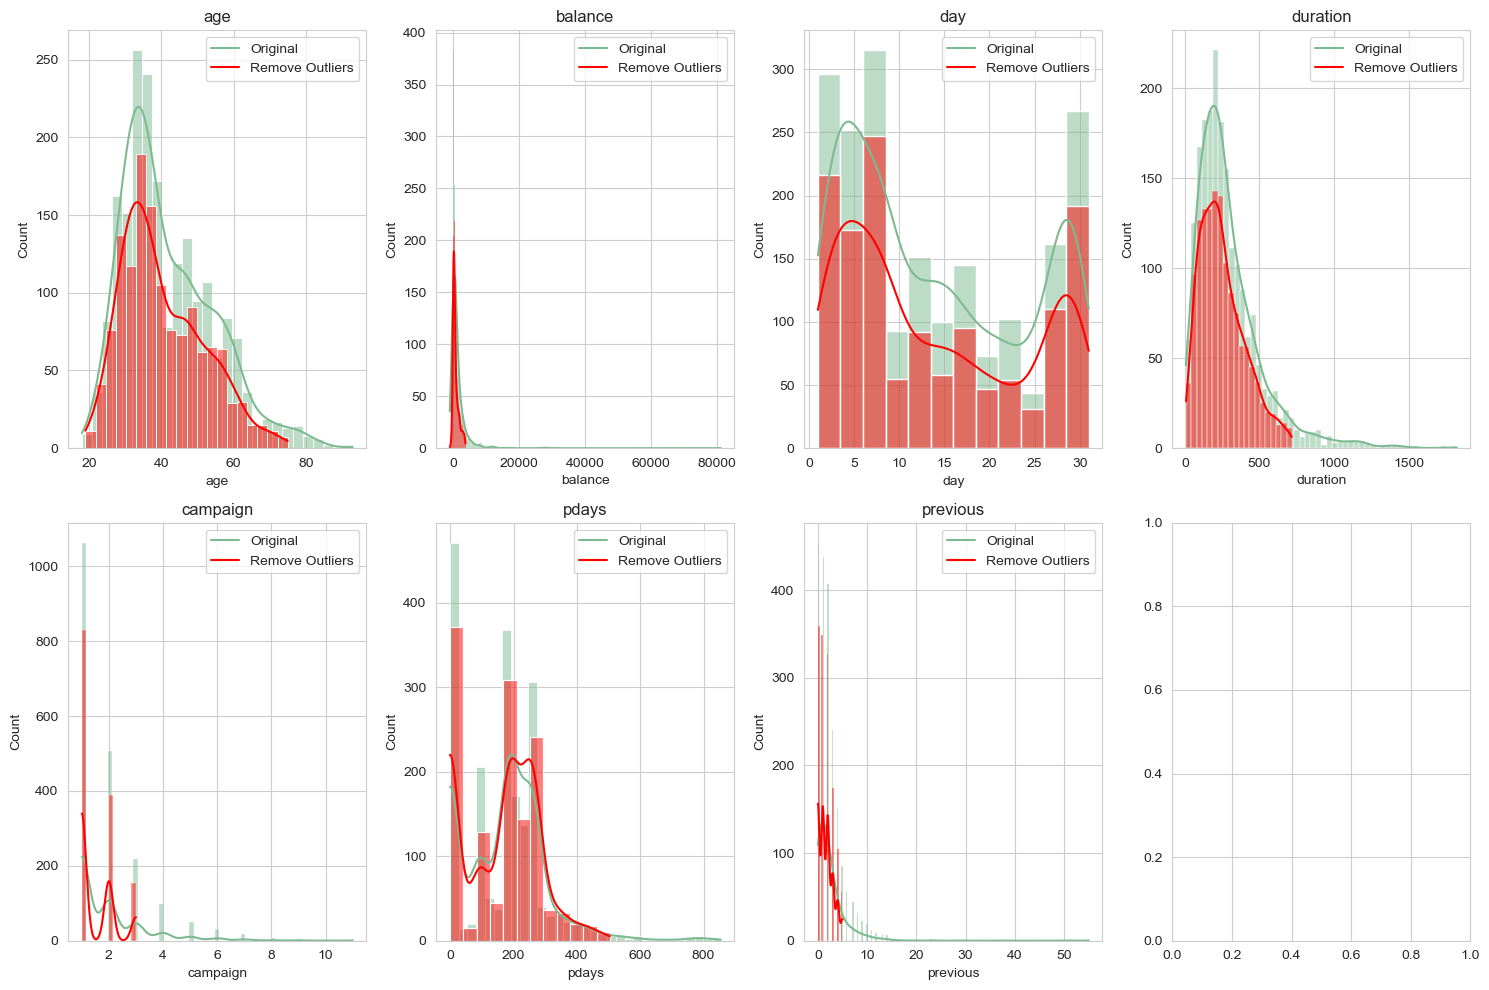

In [81]:

remove_outliers_df = filter_outliers_iqr(df, scale=1.5)

fig, axes = plt.subplots(2, 4, figsize=(15, 10))

axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(df[numeric_features]):
    sns.histplot(df[c], kde=True, ax=axes[i])
    sns.histplot(remove_outliers_df[c], kde=True, color='red', ax=axes[i])
    #sns.histplot(df_dropped[c], kde=True, color='green', ax=axes[i])
    axes[i].set_title(c)
   
    axes[i].legend(['Original', 'Remove Outliers'])

plt.tight_layout()
plt.show()

#### Filtering outliers detected by IQR (Scale 3.0)

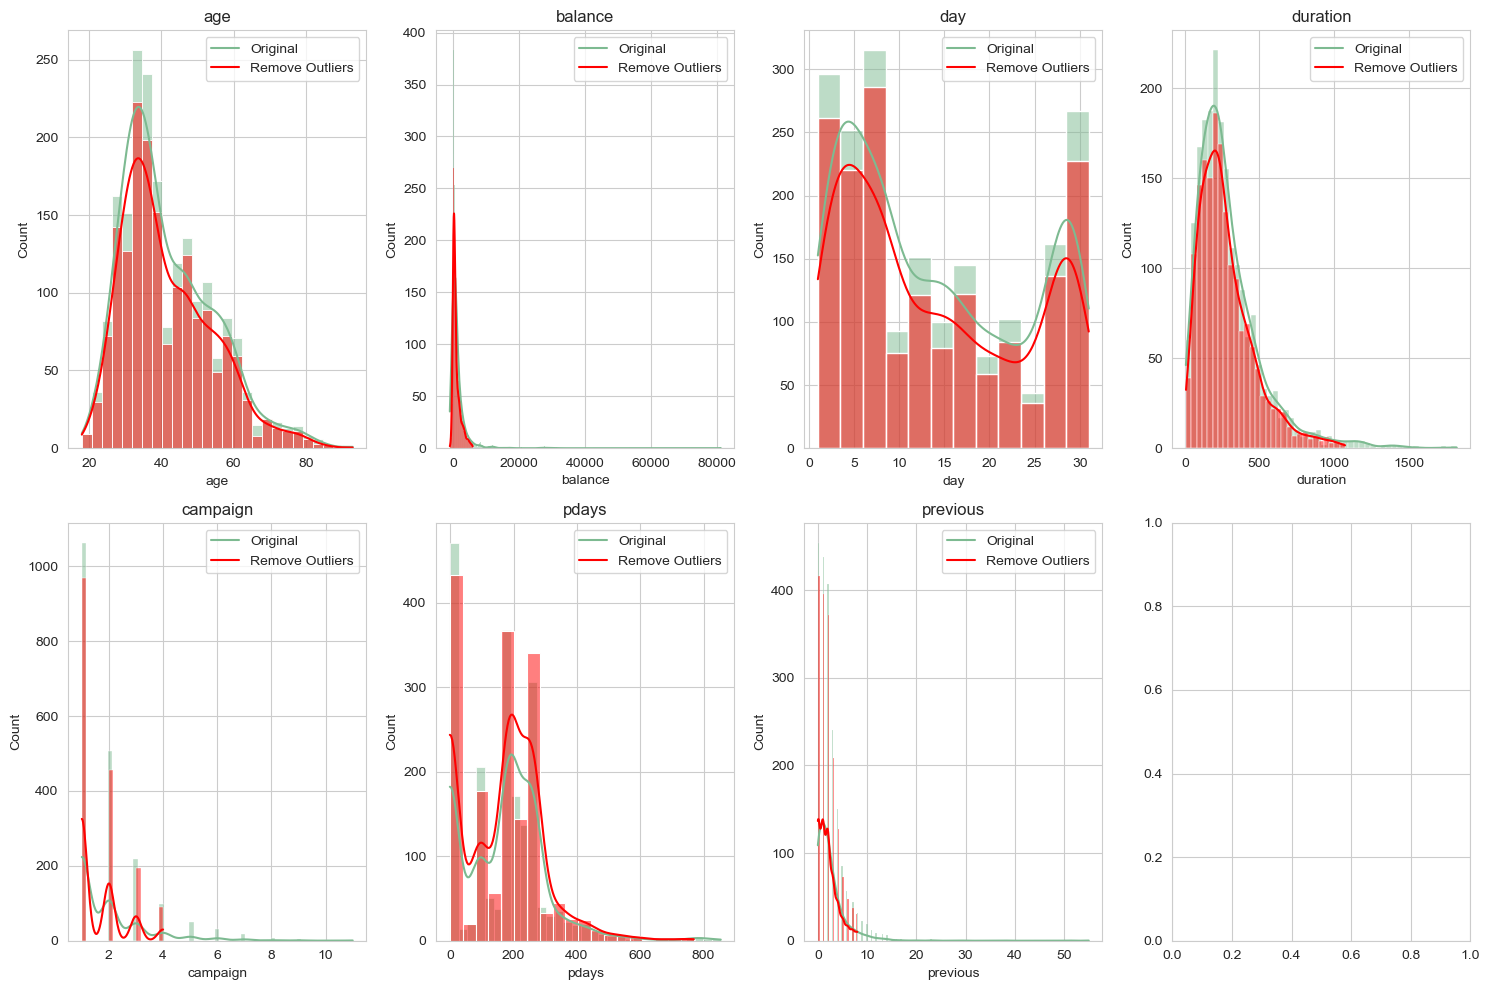

In [82]:
remove_outliers_df = filter_outliers_iqr(df, scale=3)

fig, axes = plt.subplots(2, 4, figsize=(15, 10))

axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(df[numeric_features]):
    sns.histplot(df[c], kde=True, ax=axes[i])
    sns.histplot(remove_outliers_df[c], kde=True, color='red', ax=axes[i])
    #sns.histplot(df_dropped[c], kde=True, color='green', ax=axes[i])
    axes[i].set_title(c)
   
    axes[i].legend(['Original', 'Remove Outliers'])

plt.tight_layout()
plt.show()

**Conclusion:** Removing rows with empty data and filtering outliers does not massively change the distributions.

## A4. Dealing with High Skew

**Manual Transformations**
I will investigate the use of `log transformation` for balance and previous, given their high skewness. Note, as log transformation cannot be applied to zero or negative values, and the balance does include zero or negative values, I will add a constant value (to ensure non-zero values).

For age, duration and campaign, which have moderate to strong skewness, the square root or log transformation may also be effective. I will use the sqrt approach. 

In [83]:
df = pd.read_csv('bank.csv')

# Apply transformations where needed
data_transformed = df.copy()

# Adding a small constant to 'balance' to avoid log(0) issue. The constant is chosen to be 1 more than the absolute
# value of the minimum balance, to ensure all values are positive before applying log transformation.
balance_constant = 1 - df['balance'].min()


data_transformed['log_balance'] = np.log(data_transformed['balance'] + balance_constant)
data_transformed['log_duration'] = np.log(data_transformed['duration'] + 1) # Adding 1 to avoid log(0)
data_transformed['sqrt_campaign'] = np.sqrt(data_transformed['campaign'])
data_transformed['log_previous'] = np.log(data_transformed['previous'] + 1) # Adding 1 to avoid log(0)

# Check the skewness after transformation
transformed_skewness = data_transformed[['log_balance', 'log_duration', 'sqrt_campaign', 'log_previous']].skew()

transformed_skewness

log_balance      0.312404
log_duration    -0.587374
sqrt_campaign    1.447570
log_previous     0.294855
dtype: float64

In [84]:
data_transformed['sqrt_age'] = np.sqrt(df_copy['age'])

age_transformed_skewness = data_transformed[['sqrt_age']].skew()

age_transformed_skewness

sqrt_age    0.529135
dtype: float64

- **log_balance:** Skewness reduced to 0.31, indicating a significant improvement towards a normal distribution shape.

- **log_duration:** Skewness is now -0.59, indicating a mild left skew, which is a considerable improvement from its previous right skew,. also moving towards a more 'normal' distribution shape.

- **sqrt_campaign:** Skewness reduced to 1.45, showing improvement, though still indicating a moderate right skew. This suggests that while the square root transformation helped, the data is still somewhat skewed.

- **log_previous:** Skewness reduced to 0.29, indicating a very slight right skew and a significant improvement towards normality.

 Plot histograms of the newly transformed variables (beside the original values).

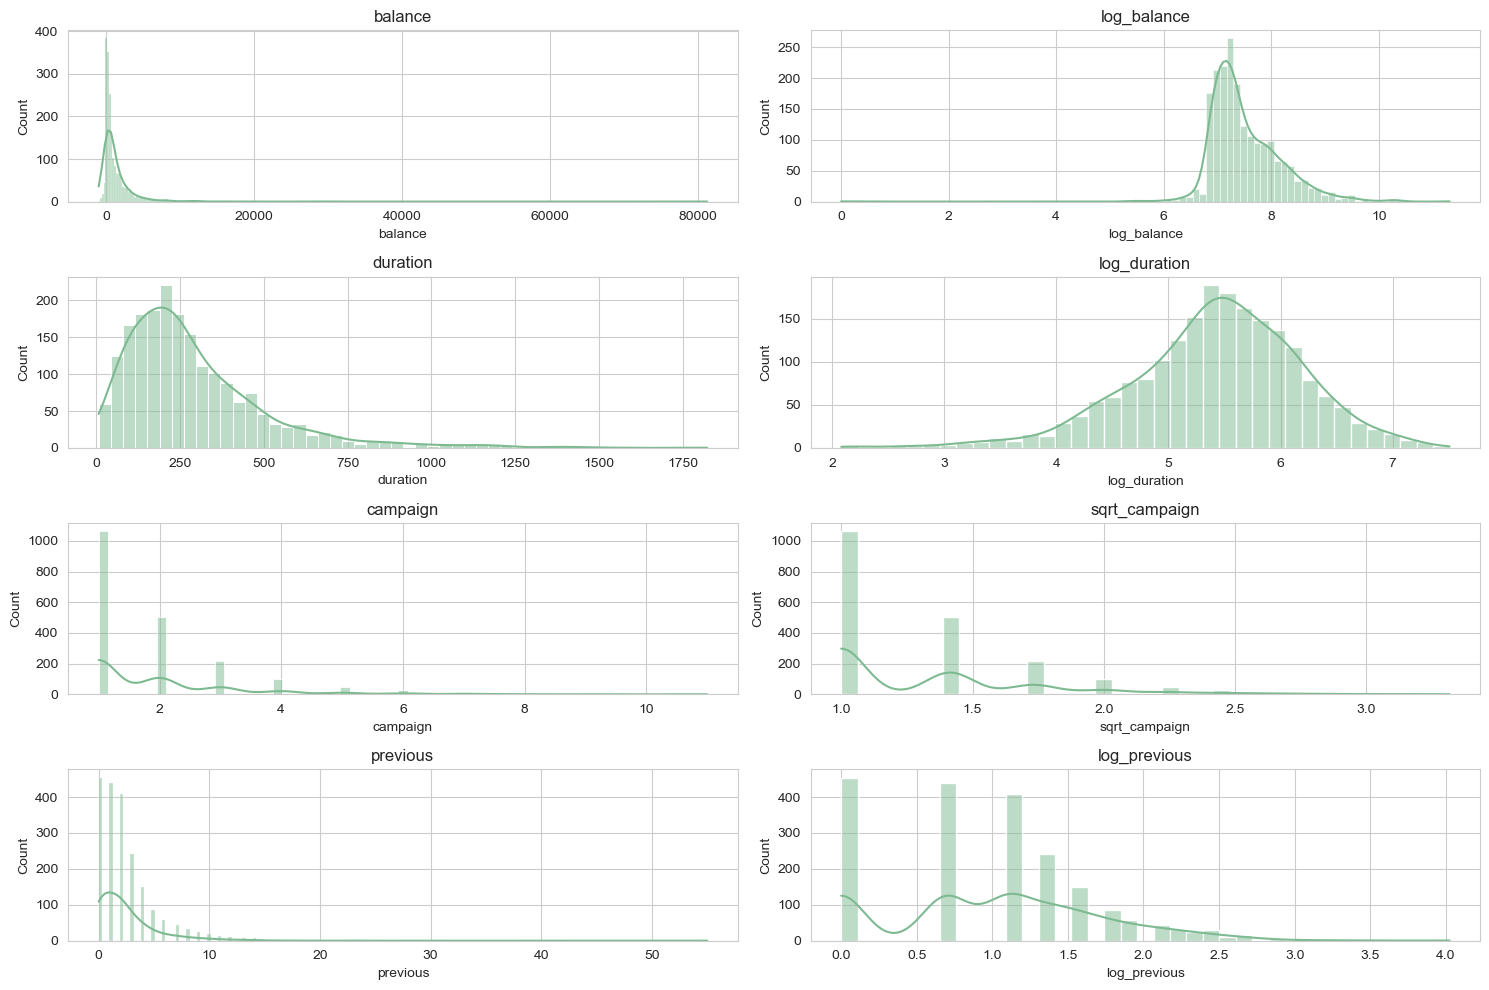

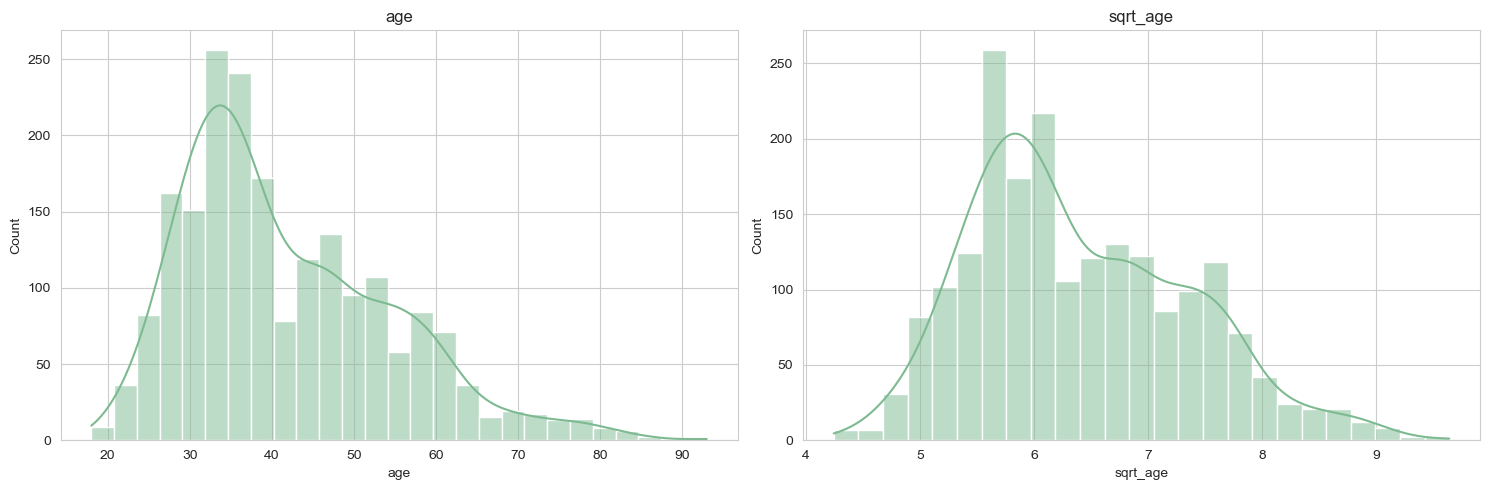

In [85]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10))

axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(['balance','log_balance', 
                       'duration', 'log_duration', 
                       'campaign', 'sqrt_campaign', 
                       'previous','log_previous']):
    sns.histplot(data_transformed[c], kde=True, ax=axes[i])
    axes[i].set_title(c)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_transformed['age'], kde=True, ax=axes[0])
axes[0].set_title('age')

sns.histplot(data_transformed['sqrt_age'], kde=True, ax=axes[1])
axes[1].set_title('sqrt_age')

plt.tight_layout()
plt.show()

We can see that this has a slight impact on the centering of the age data.

## A5. Plot feature Importance
Here I use a random forest classifier to show importance vs the Subscribed target variable. Note I will load the preprocessed bank csv, rather than the original.

Test Accuracy: 0.97


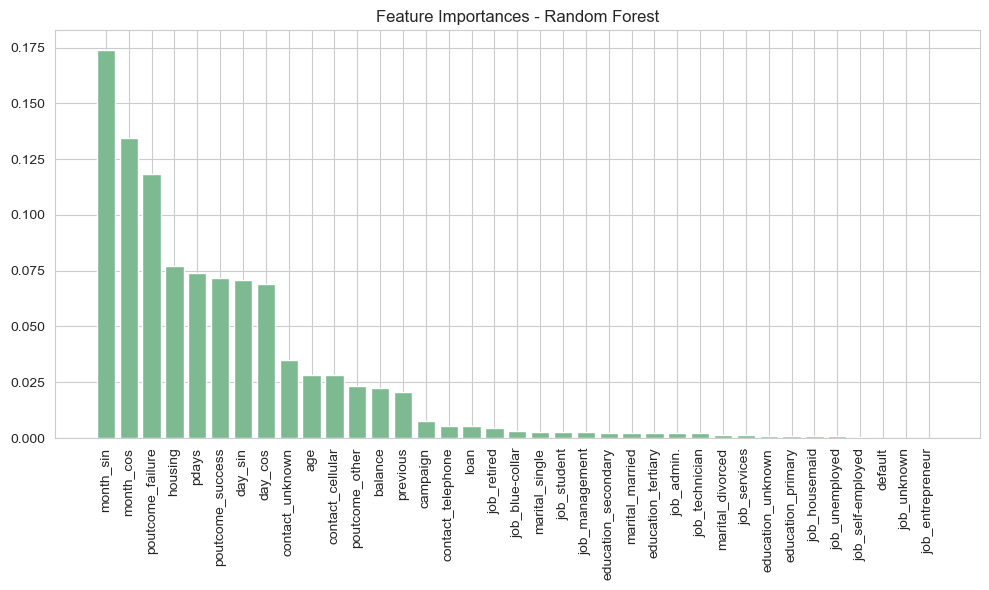

Top Most Important Features:
month_sin           0.174033
month_cos           0.134402
poutcome_failure    0.118367
housing             0.077185
pdays               0.073941
poutcome_success    0.071736
day_sin             0.070710
day_cos             0.068916
contact_unknown     0.034986
age                 0.028373
dtype: float64


In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Let's use the preprocessed file we hand-generated.
df = pd.read_csv('bank_preprocessed_manual.csv')

y = df['subscribed']  # Target variable
X = df.drop('subscribed', axis=1)  # Feature matrix

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise and train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Calculate test accuracy
test_accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get feature importances
feature_importances = clf.feature_importances_
feature_names = X.columns

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(X.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Create a Series for the feature importances, making sure to match each with its feature name
importances = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Print the top most important features
print("Top Most Important Features:")
print(sorted_importances.head(10))

We see that, according to the random forest, the most important fields (once transformed) are month, poutcome followed by the rest.

## A6. Demonstrate that the Manual and Pipeline-created CSVs are identical
This next utility confirms that the manually preprocessed csv and the pipeline processed csv do the same thing. I do this by loading both csvs and comparing the values, field-by-field, rowby row.

In [87]:
# Load the CSV files into DataFrames
df1 = pd.read_csv('bank_preprocessed_manual.csv')
df2 = pd.read_csv('bank_preprocessed_pipeline.csv')

# Ensure both DataFrames contain the same set of columns, ignoring the order
if set(df1.columns) != set(df2.columns):
    print("DataFrames have different columns. Ensure they have the same set of columns for a meaningful comparison.")
else:
    # Align df2 to have the same column order as df1 based on the column names
    df2 = df2[df1.columns]

    def compare_dataframes(df1, df2):
        # Loop through each column to compare values
        for column in df1.columns:
            # Create a mask of rows where the current column's values differ between the two DataFrames
            diff_mask = df1[column] != df2[column]
            
            # Report differences, if any
            if diff_mask.any():
                print(f"Differences found in column '{column}':")
                # Display the differences with index for identification
                differences = pd.concat([df1.loc[diff_mask, column], df2.loc[diff_mask, column]], axis=1, keys=['DF1', 'DF2'])
                print(differences)
            else:
                print(f"Column '{column}' is identical in both DataFrames.")

    # Call the function to compare the two DataFrames
    compare_dataframes(df1, df2)

Differences found in column 'age':
           DF1       DF2
0    -0.767012 -0.768987
1    -0.215233 -0.217065
2     1.361277  1.359857
3     0.415371  0.413704
4     0.967150  0.965627
...        ...       ...
1995 -1.712918 -1.715141
1996 -1.082314 -1.084372
1997  3.095439  3.094471
1998  0.336546  0.334858
1999 -0.136408 -0.138219

[2000 rows x 2 columns]
Column 'default' is identical in both DataFrames.
Column 'balance' is identical in both DataFrames.
Column 'housing' is identical in both DataFrames.
Column 'loan' is identical in both DataFrames.
Column 'campaign' is identical in both DataFrames.
Column 'pdays' is identical in both DataFrames.
Column 'previous' is identical in both DataFrames.
Column 'subscribed' is identical in both DataFrames.
Column 'job_admin.' is identical in both DataFrames.
Column 'job_blue-collar' is identical in both DataFrames.
Column 'job_entrepreneur' is identical in both DataFrames.
Column 'job_housemaid' is identical in both DataFrames.
Column 'job_ma